Walmart Store Sales Forecasting





In [ ]:
# importing all the required libraries and modules
import numpy as np
import pandas as pd 
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Data Processing

In [ ]:
train = pd.read_csv('/train.csv.zip')
test = pd.read_csv('/test.csv.zip')
stores = pd.read_csv('/stores.csv')
features = pd.read_csv('/features.csv.zip')

In [ ]:
train.info()
stores.info()
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        ---------

In [ ]:
df = train.merge(stores, how='left').merge(features, how='left')

In [ ]:
test_merge = test.merge(stores, how='left').merge(features, how='left')

In [ ]:
def split_date(df0):
    df0['Date'] = pd.to_datetime(df0['Date'])
    df0['Year'] = df0['Date'].dt.year
    df0['Month'] = df0['Date'].dt.month
    df0['Day'] = df0['Date'].dt.day
    df0['Week_of_year'] = df0['Date'].dt.isocalendar().week*1.0
    return df0.head(5)

In [ ]:
split_date(df)
split_date(test_merge)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Week_of_year
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,2012,11,2,44.0
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,2012,11,9,45.0
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,2012,11,16,46.0
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,2012,11,23,47.0
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,2012,11,30,48.0


In [ ]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Year                 0
Month                0
Day                  0
Week_of_year         0
dtype: int64


Exploratory data analysis

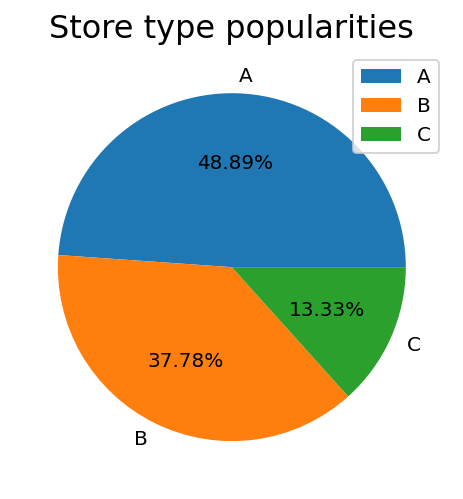

In [ ]:
type_counts = stores.groupby('Type')['Store'].count().to_dict()
store_type = pd.DataFrame(list(type_counts.items()), columns=['Type', 'Counts'])
plt.pie(store_type.Counts, labels=store_type.Type, autopct='%.2f%%')
plt.title('Store type popularities', fontsize=16)
plt.legend(store_type.Type, loc='best')
plt.show()

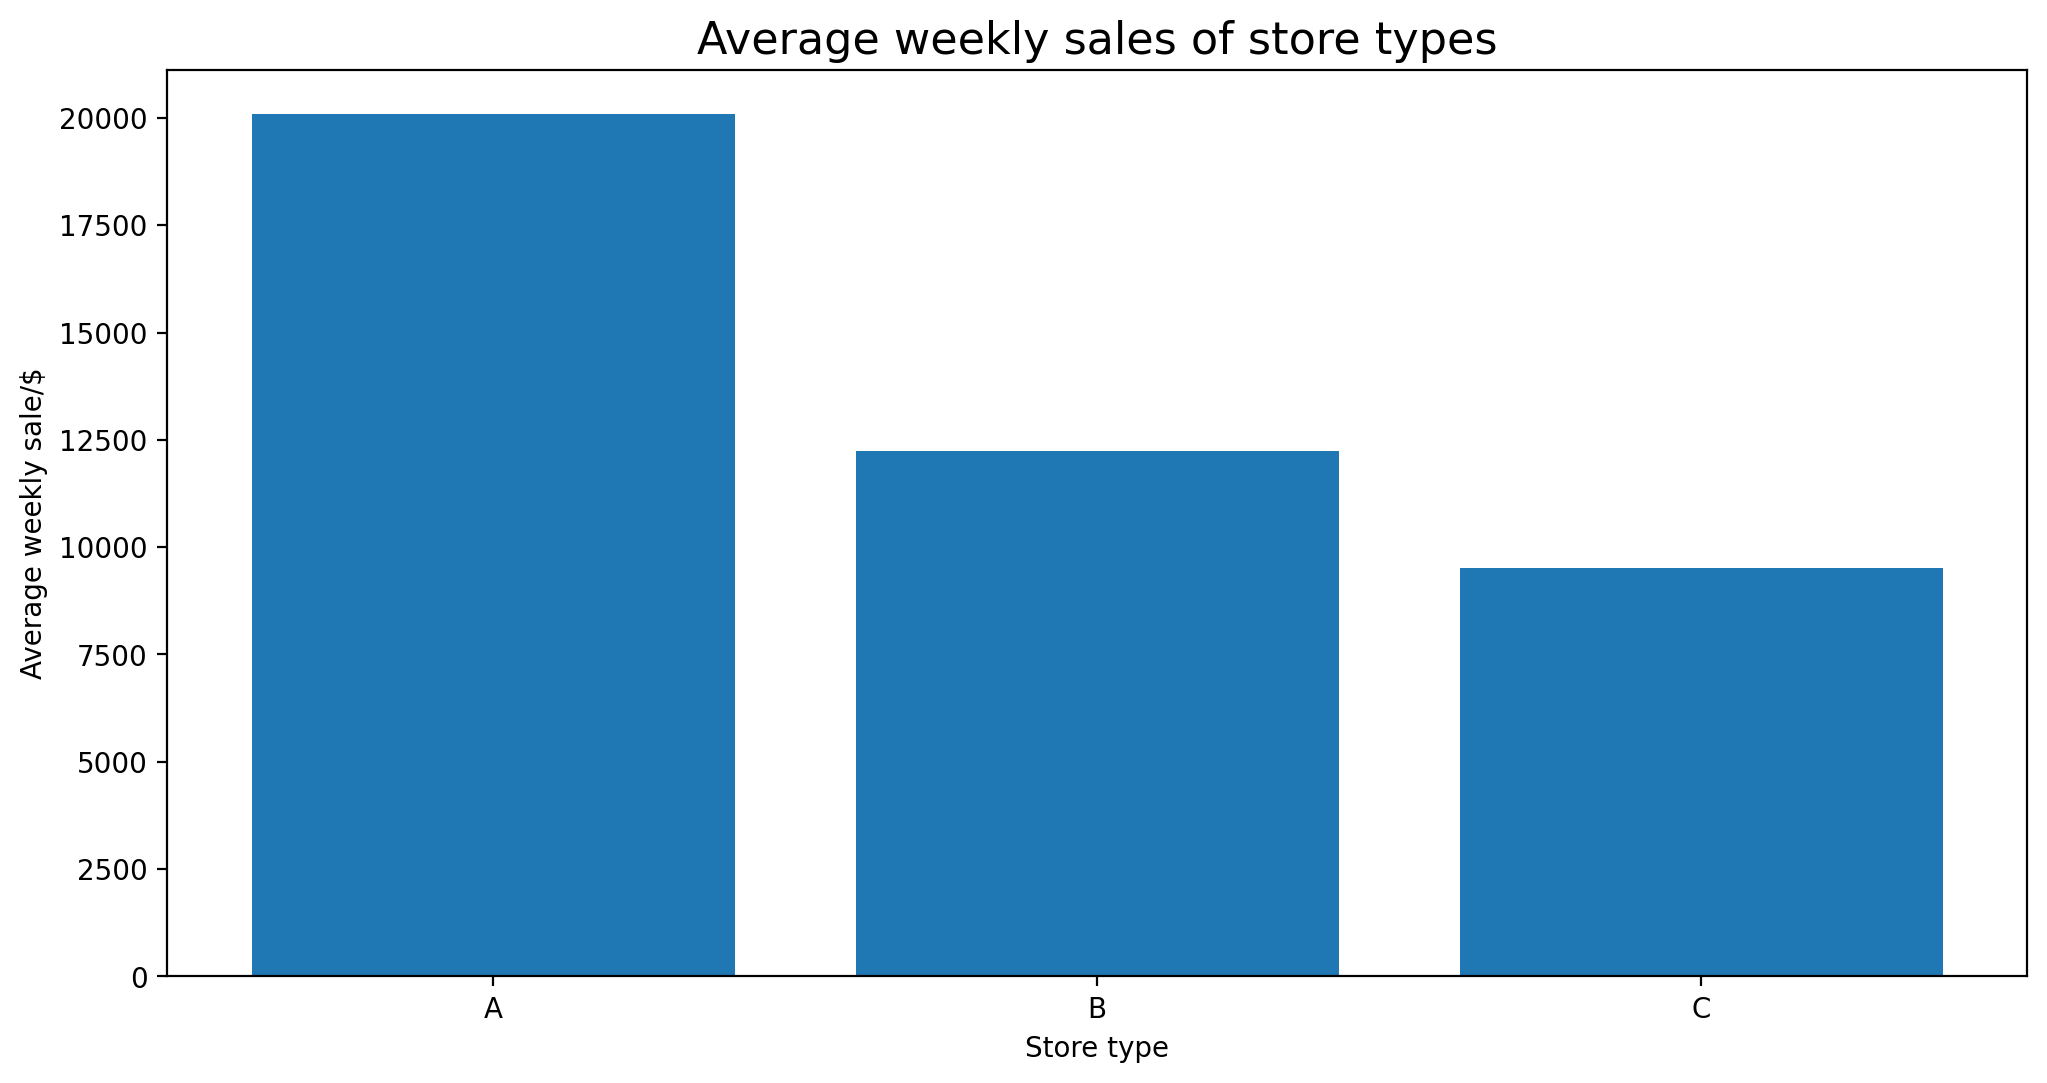

In [ ]:
type_sales =  df.groupby('Type')['Weekly_Sales'].mean().to_dict()
type_sales = pd.DataFrame(list(type_sales.items()), columns=['Type', 'AVG weekly_sales'])
plt.figure(figsize=(12,6), dpi=100)
plt.bar(type_sales.Type, type_sales['AVG weekly_sales'])
plt.title('Average weekly sales of store types', fontsize=16)
plt.xlabel('Store type')
plt.ylabel('Average weekly sale/$')
plt.show()

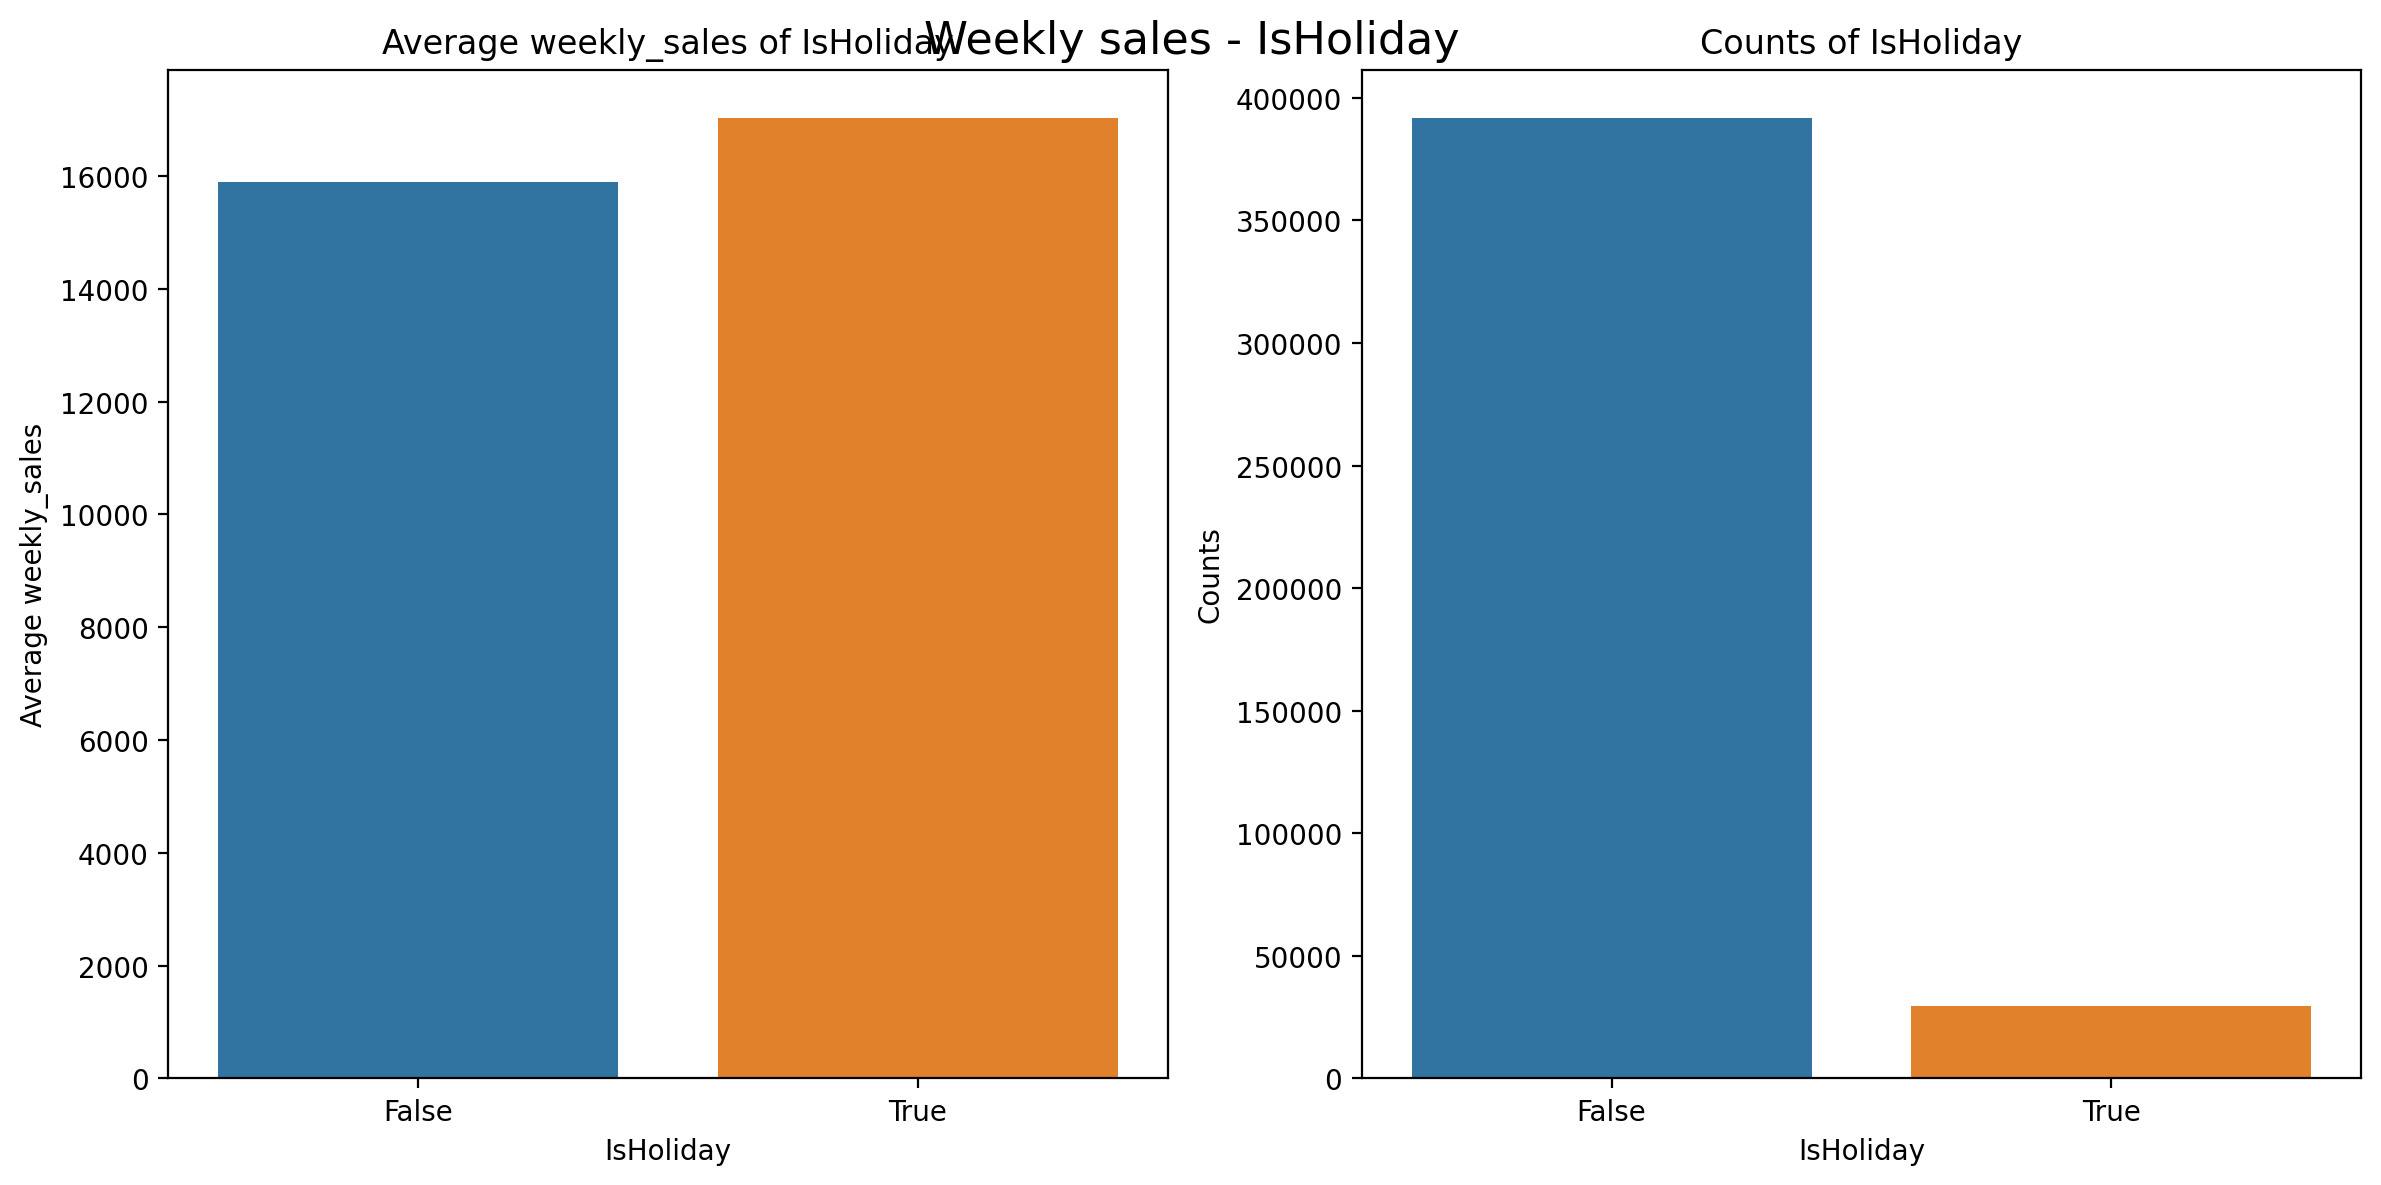

In [ ]:
holiday_sale = df.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_count = df.groupby('IsHoliday')['Weekly_Sales'].count()

fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)

ax1 = sns.barplot(x=holiday_sale.index, y=holiday_sale.values, ax=axes[0])
ax1.set_title('Average weekly_sales of IsHoliday')
ax1.set_xlabel('IsHoliday')
ax1.set_ylabel('Average weekly_sales')

ax2 = sns.barplot(x=holiday_count.index,y=holiday_count.values, ax=axes[1])
ax2.set_title('Counts of IsHoliday')
ax2.set_xlabel('IsHoliday')
ax2.set_ylabel('Counts')

plt.suptitle('Weekly sales - IsHoliday', fontsize = 16)
fig.tight_layout()
plt.show()

In [ ]:
year_2010 = pd.DataFrame(df.loc[df['Year']==2010].groupby('Week_of_year')['Weekly_Sales'].sum()).reset_index()
year_2011 = pd.DataFrame(df.loc[df['Year']==2011].groupby('Week_of_year')['Weekly_Sales'].sum()).reset_index()
year_2012 = pd.DataFrame(df.loc[df['Year']==2012].groupby('Week_of_year')['Weekly_Sales'].sum()).reset_index()

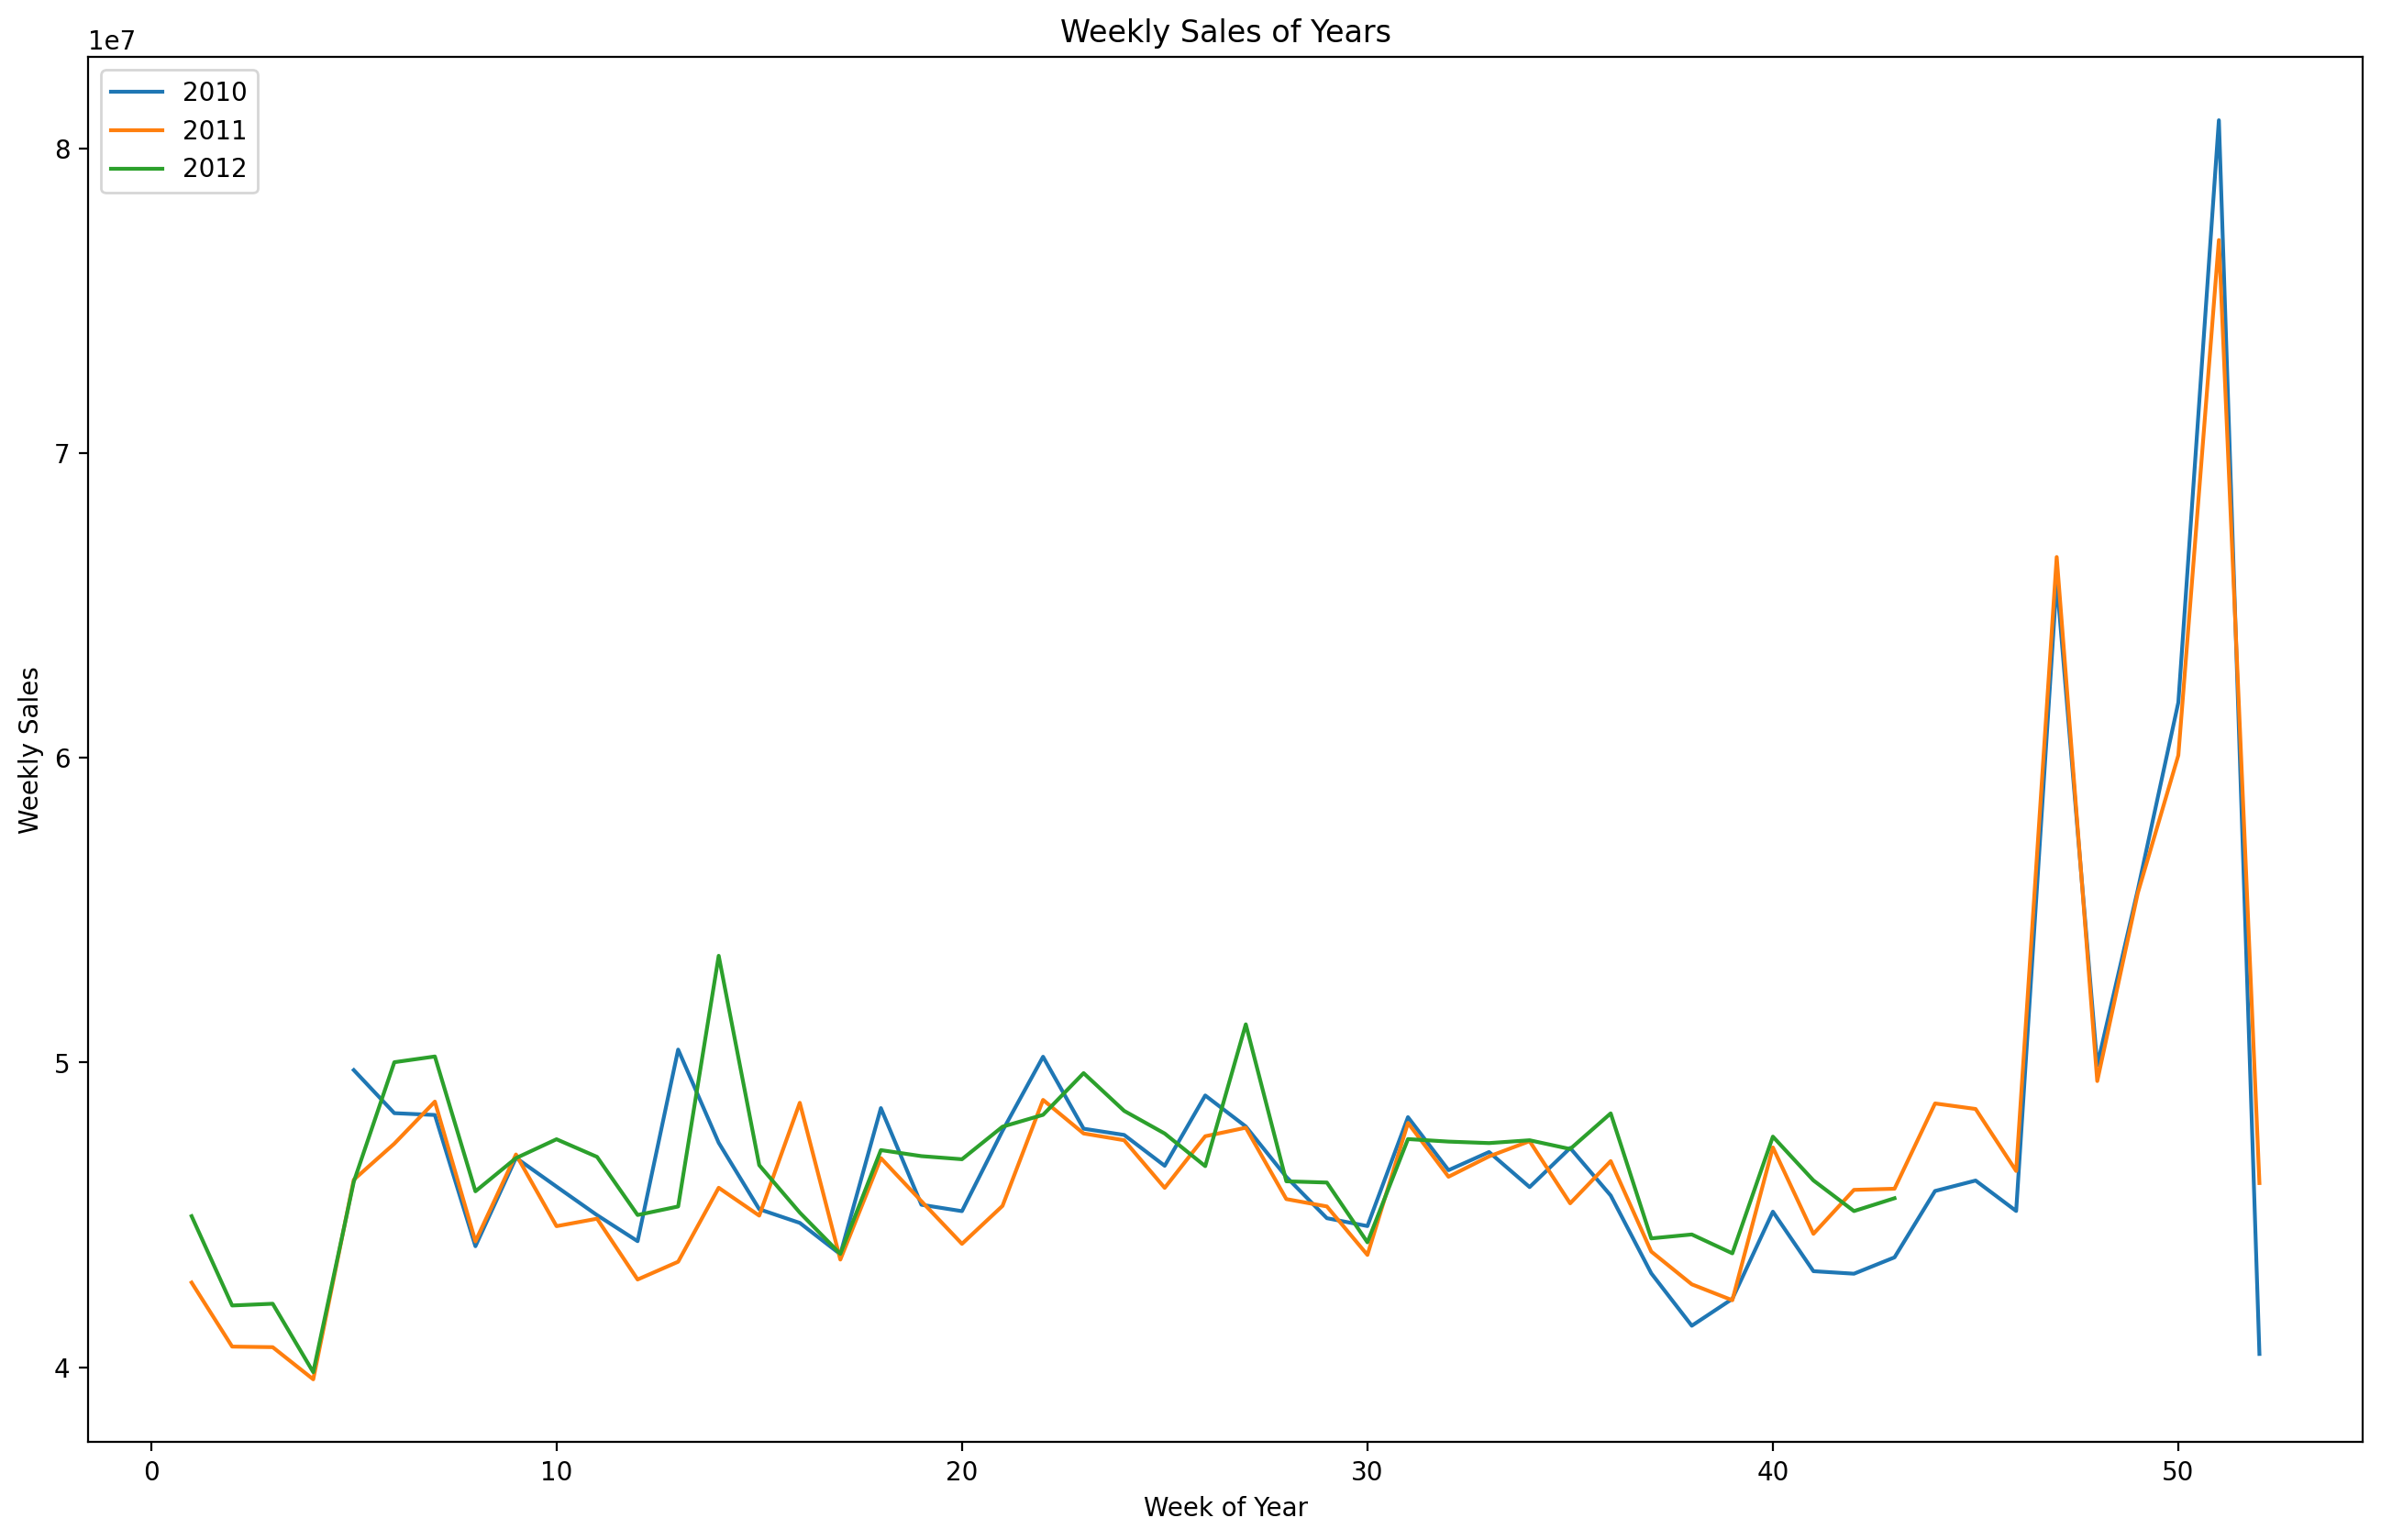

In [ ]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(year_2010['Week_of_year'], year_2010['Weekly_Sales'], label='2010')
plt.plot(year_2011['Week_of_year'], year_2011['Weekly_Sales'], label='2011')
plt.plot(year_2012['Week_of_year'], year_2012['Weekly_Sales'], label='2012')

plt.legend(loc='best')
plt.xlabel('Week of Year')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales of Years')

plt.show()

In [ ]:
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Week_of_year
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5.0
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,12,6.0
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,19,7.0
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,26,8.0
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,5,9.0


Machine Learning Model

Since we have 20 columns in total, we need to reduce the dimensionality using correlation matrix, which is only for numeric values, and the 'Type' column needs to be transferred.



In [ ]:
df['Type_trans'] = df['Type'].map({'A':1, 'B':2, 'C':3})
test_merge['Type_trans'] = test_merge['Type'].map({'A':1, 'B':2, 'C':3})


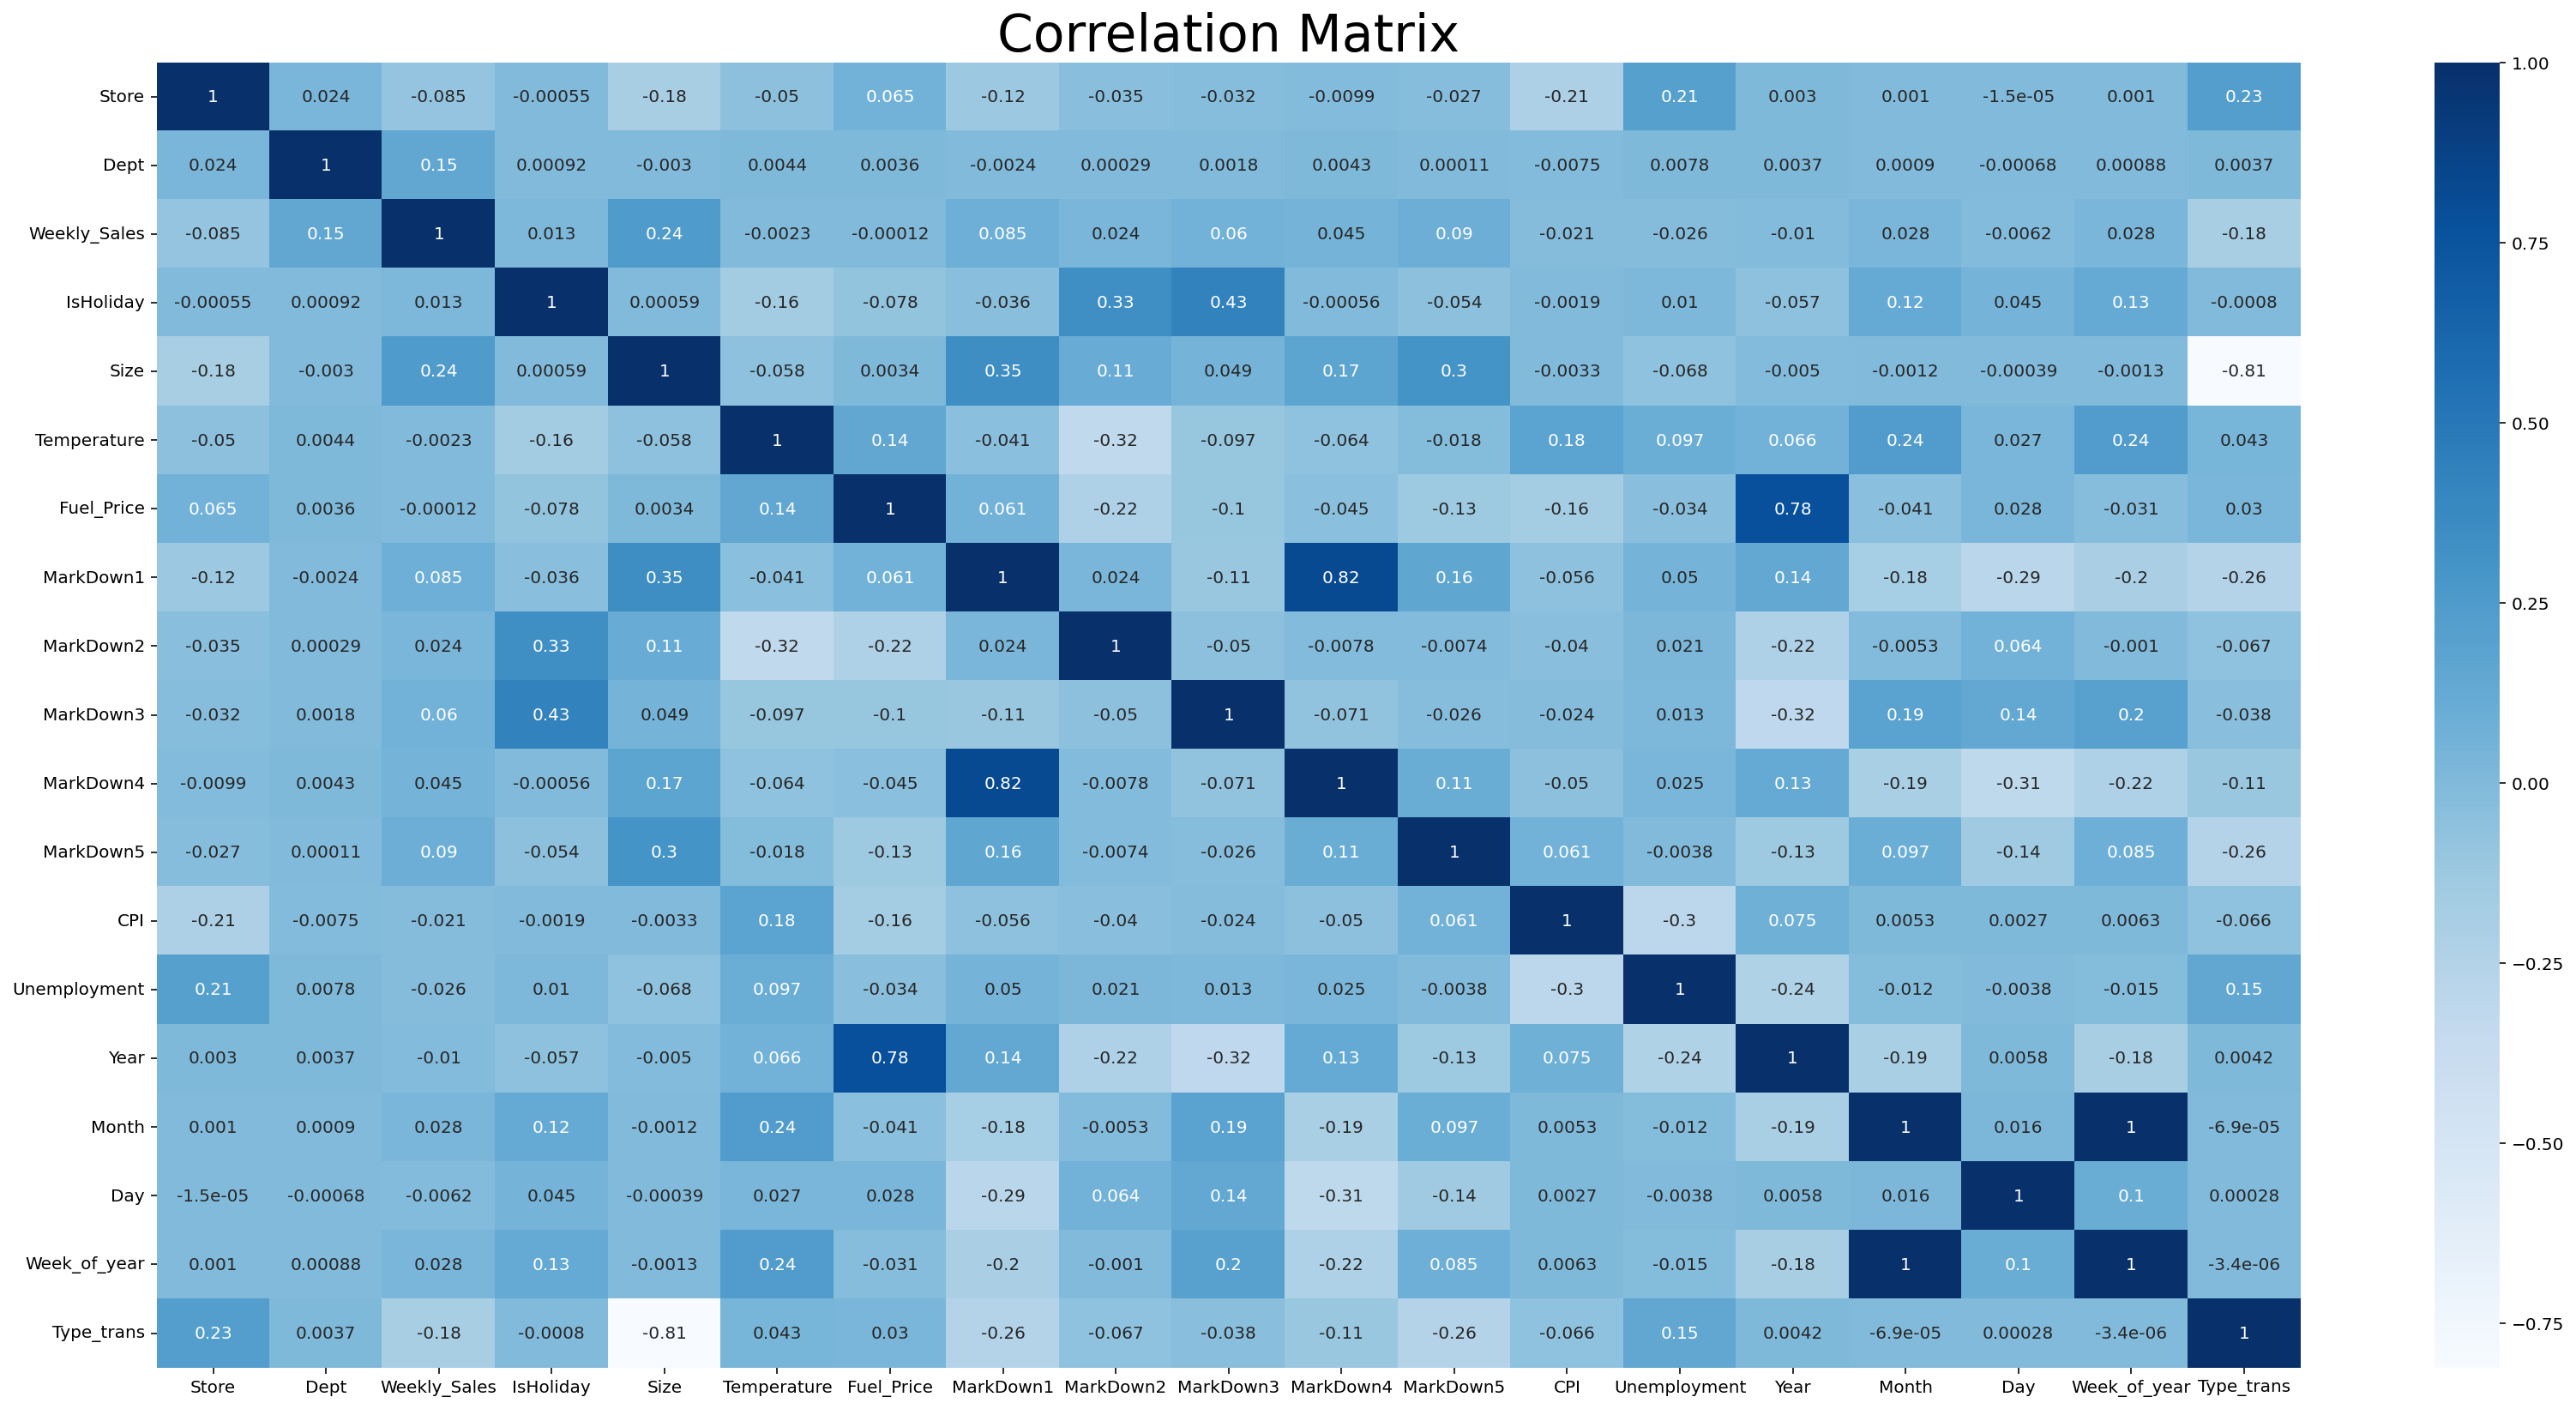

In [ ]:
plt.figure(figsize=(28,14))
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.title('Correlation Matrix', fontsize=30)
plt.show()

The Tempeature, Fuel price, MarkDown#, CPI, Unemployment will be removed due to its low correlationship with Weekly sales, and the month, day columns will also be dropped because of the redundant information.



In [ ]:
df_model = df.drop(columns=['Temperature', 'Type', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                'CPI', 'Unemployment', 'Date', 'Month', 'Day'])
test_merge_model = test_merge.drop(columns=['Temperature', 'Type', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                'CPI', 'Unemployment', 'Date', 'Month', 'Day'])

In [ ]:
X = df_model.drop(columns=['Weekly_Sales'])
y = df_model['Weekly_Sales']

The range among different colunms varies a lot, so scaling the data is needed.



In [ ]:
scaler = MinMaxScaler().fit(X)
X_scaler = pd.DataFrame(scaler.transform(X), columns=X.columns)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaler, y, test_size=0.2, random_state=47)

From the previous analysis, the 'IsHoliday' feature is important to the weekly sales, and we need to use WMAE (weighted mean absolute error) to evalute our model.



In [ ]:
def WMAE(data, prediction, actual):
    weights = data['IsHoliday'].apply(lambda x: 5 if x==1 else 1)
    return np.round(np.sum(weights*abs(prediction-actual))/weights.sum(), 2)

1. Linear regression



In [ ]:
#build the model
model1 = LinearRegression().fit(X_train, y_train)
#training error
linear_train_wmae = WMAE(X_train, model1.predict(X_train), y_train)
#validation error
y_pred = model1.predict(X_val)
linear_val_wmae = WMAE(X_val, y_pred, y_val)
#results
print('Training dataset WMAE is', linear_train_wmae)
print('Validation dataset WMAE is', linear_val_wmae)

Training dataset WMAE is 14802.19
Validation dataset WMAE is 14838.9


It seems that there is no noticeable variance between training dataset and validation dataset, and we continue to compare them with the Ridge model.



2. Ridge Regression



In [ ]:
model2 = Ridge().fit(X_train, y_train)
#train error
ridge_train_wmae = WMAE(X_train, model2.predict(X_train), y_train)

#validation error
y_pred = model2.predict(X_val)
ridge_val_wmae = WMAE(X_val, y_pred, y_val)

#results:
print('Training dataset WMAE is', ridge_train_wmae)
print('Validation dataset WMAE is', ridge_val_wmae)

Training dataset WMAE is 14802.17
Validation dataset WMAE is 14838.88


There is no need to worry about the overfitting problem.



3. Decision tree



In [ ]:
model3 = DecisionTreeRegressor(random_state=123).fit(X_train, y_train)
#train error
tree_train_wmae = WMAE(X_train, model3.predict(X_train), y_train)

#validation error
y_pred = model3.predict(X_val)
tree_val_wmae = WMAE(X_val, y_pred, y_val)

#results:
print('Training dataset WMAE is', tree_train_wmae)
print('Validation dataset WMAE is', tree_val_wmae)


Training dataset WMAE is 0.0
Validation dataset WMAE is 1794.8


In [ ]:
tree_importance = pd.DataFrame(np.transpose(model3.feature_importances_),
                               index=X_train.columns, columns=['Importance']).sort_values(by='Importance',
                                                                                          ascending=False)
                                                                                                           
tree_importance


,Importance
Dept,0.632394
Size,0.202965
Store,0.076129
Week_of_year,0.063820
Type_trans,0.014868
Year,0.007306
IsHoliday,0.002518


The department of a store contributes most to the change of weekly sales.



4. Random Forest



In [ ]:
model4 = RandomForestRegressor(random_state=123, n_jobs=-1).fit(X_train, y_train)
#train error
forest_train_wmae = WMAE(X_train, model3.predict(X_train), y_train)

#validation error
y_pred = model3.predict(X_val)
forest_val_wmae = WMAE(X_val, y_pred, y_val)

#results:
print('Training dataset WMAE is', forest_train_wmae)
print('Validation dataset WMAE is', forest_val_wmae)

Training dataset WMAE is 0.0
Validation dataset WMAE is 1794.8


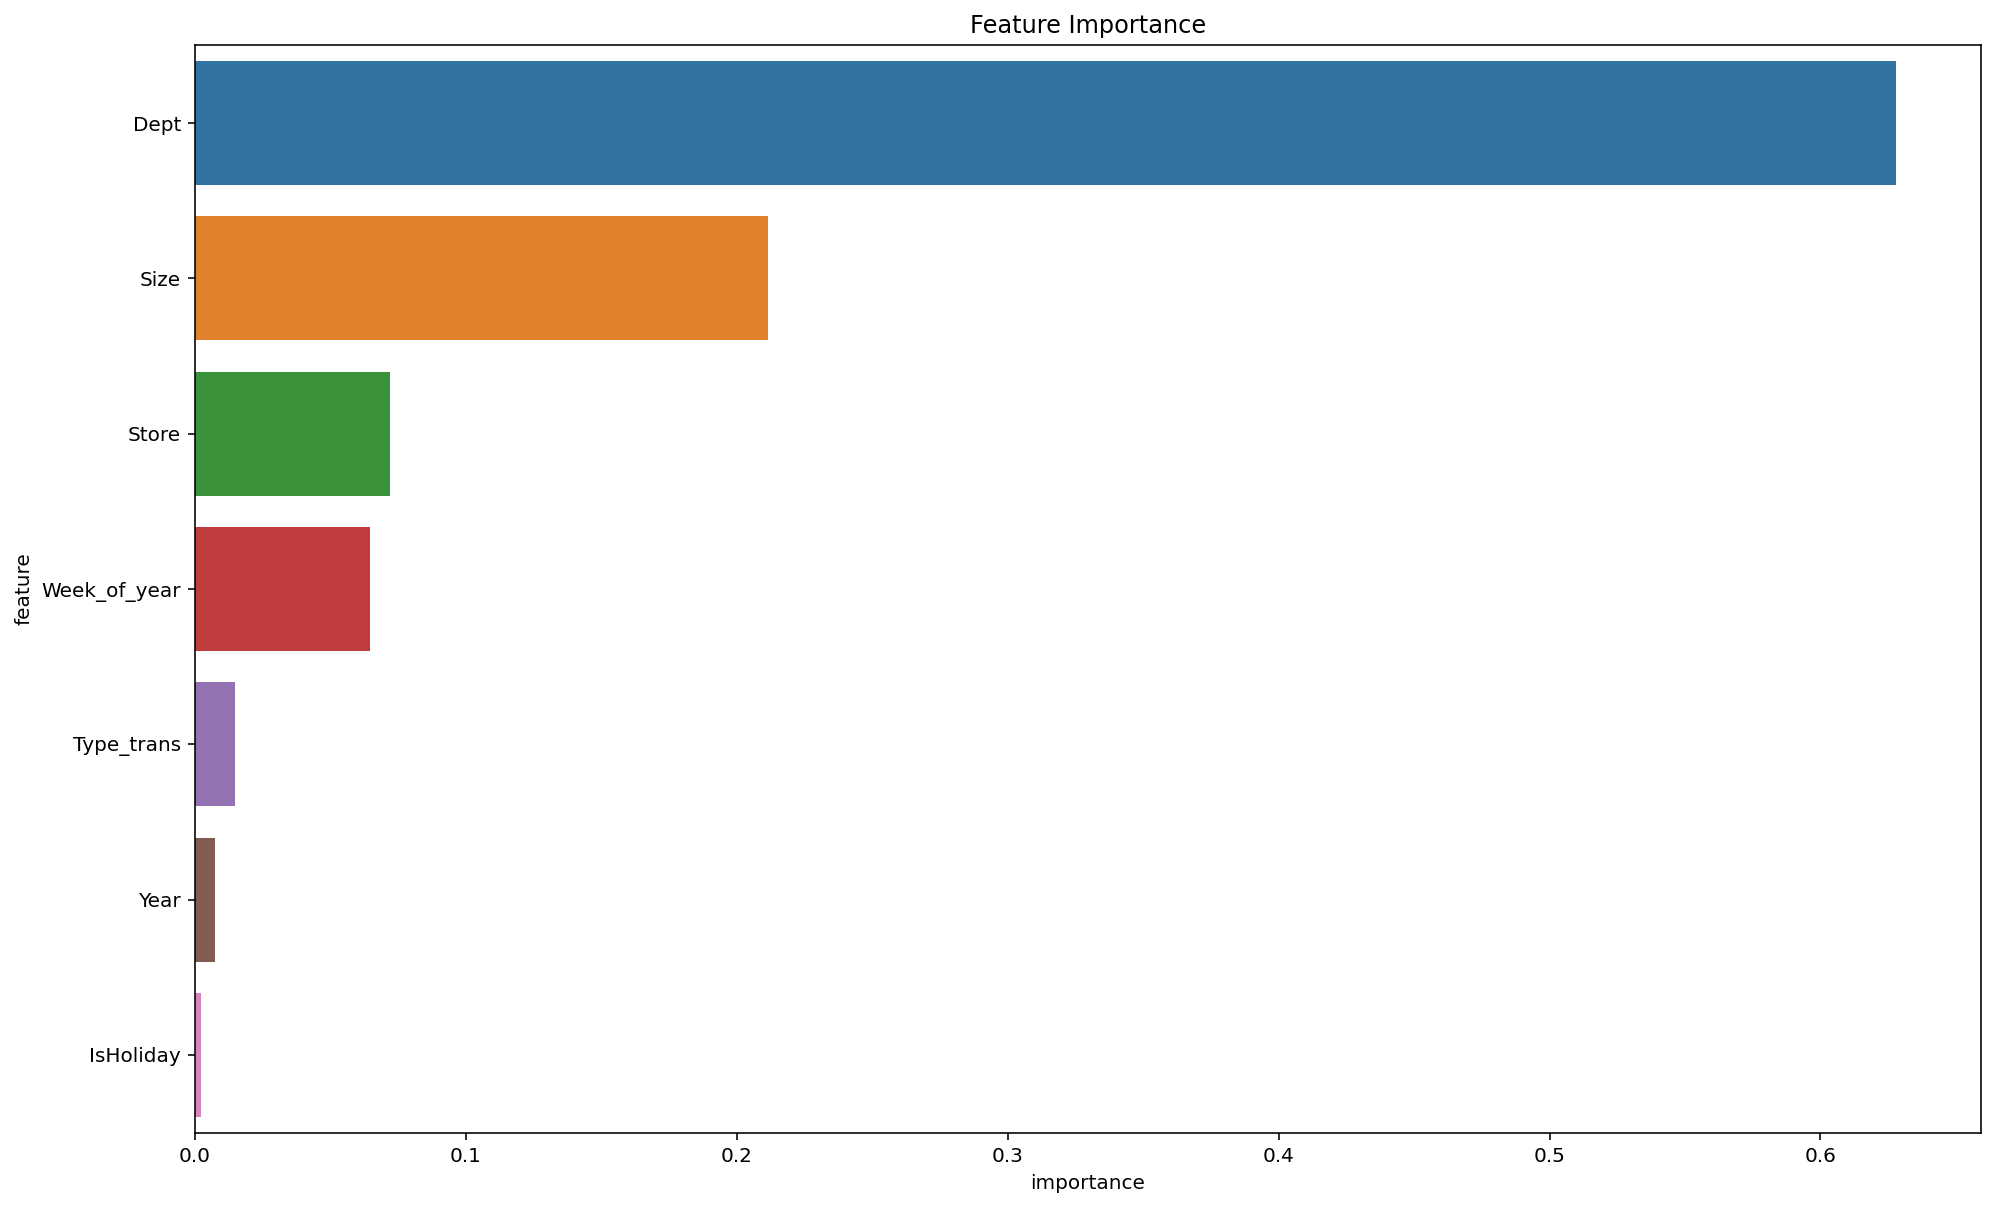

In [ ]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model4.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

RandomForest Hyperparameter Tuning

There are many hyperparameters in RandomForest model, and these together influence the performance of the model. In this case, finding the best one from finite combinations is needed. And I choose 'n_estimators', 'max_depth', 'min_samples_split', 'max_features'.

In [ ]:
def test_params(**params):  
    model = RandomForestRegressor(random_state=123, n_jobs=-1, **params).fit(X_train, y_train)
    train_wmae = WMAE(X_train, y_train, model.predict(X_train))
    val_wmae = WMAE(X_val, y_val, model.predict(X_val))
    return train_wmae, val_wmae

In [ ]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params(**params)
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('WMAE')
    plt.legend(['Training', 'Validation'])

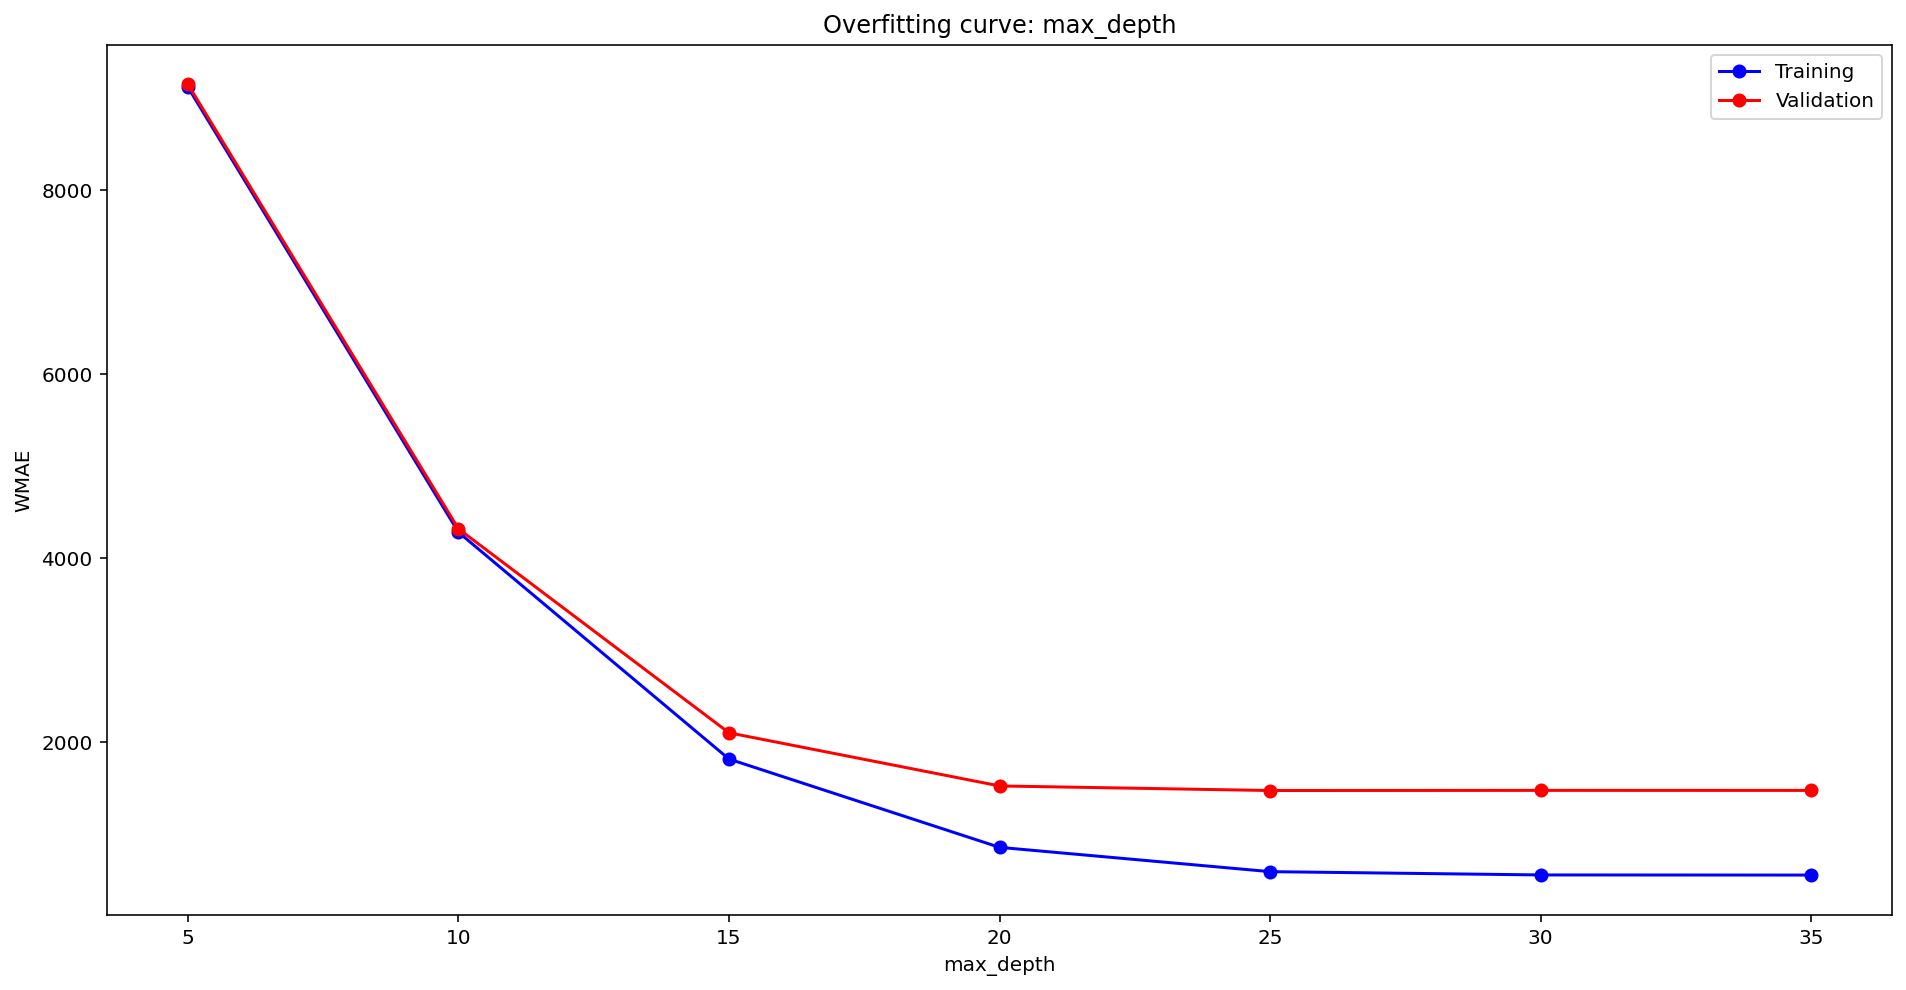

In [ ]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

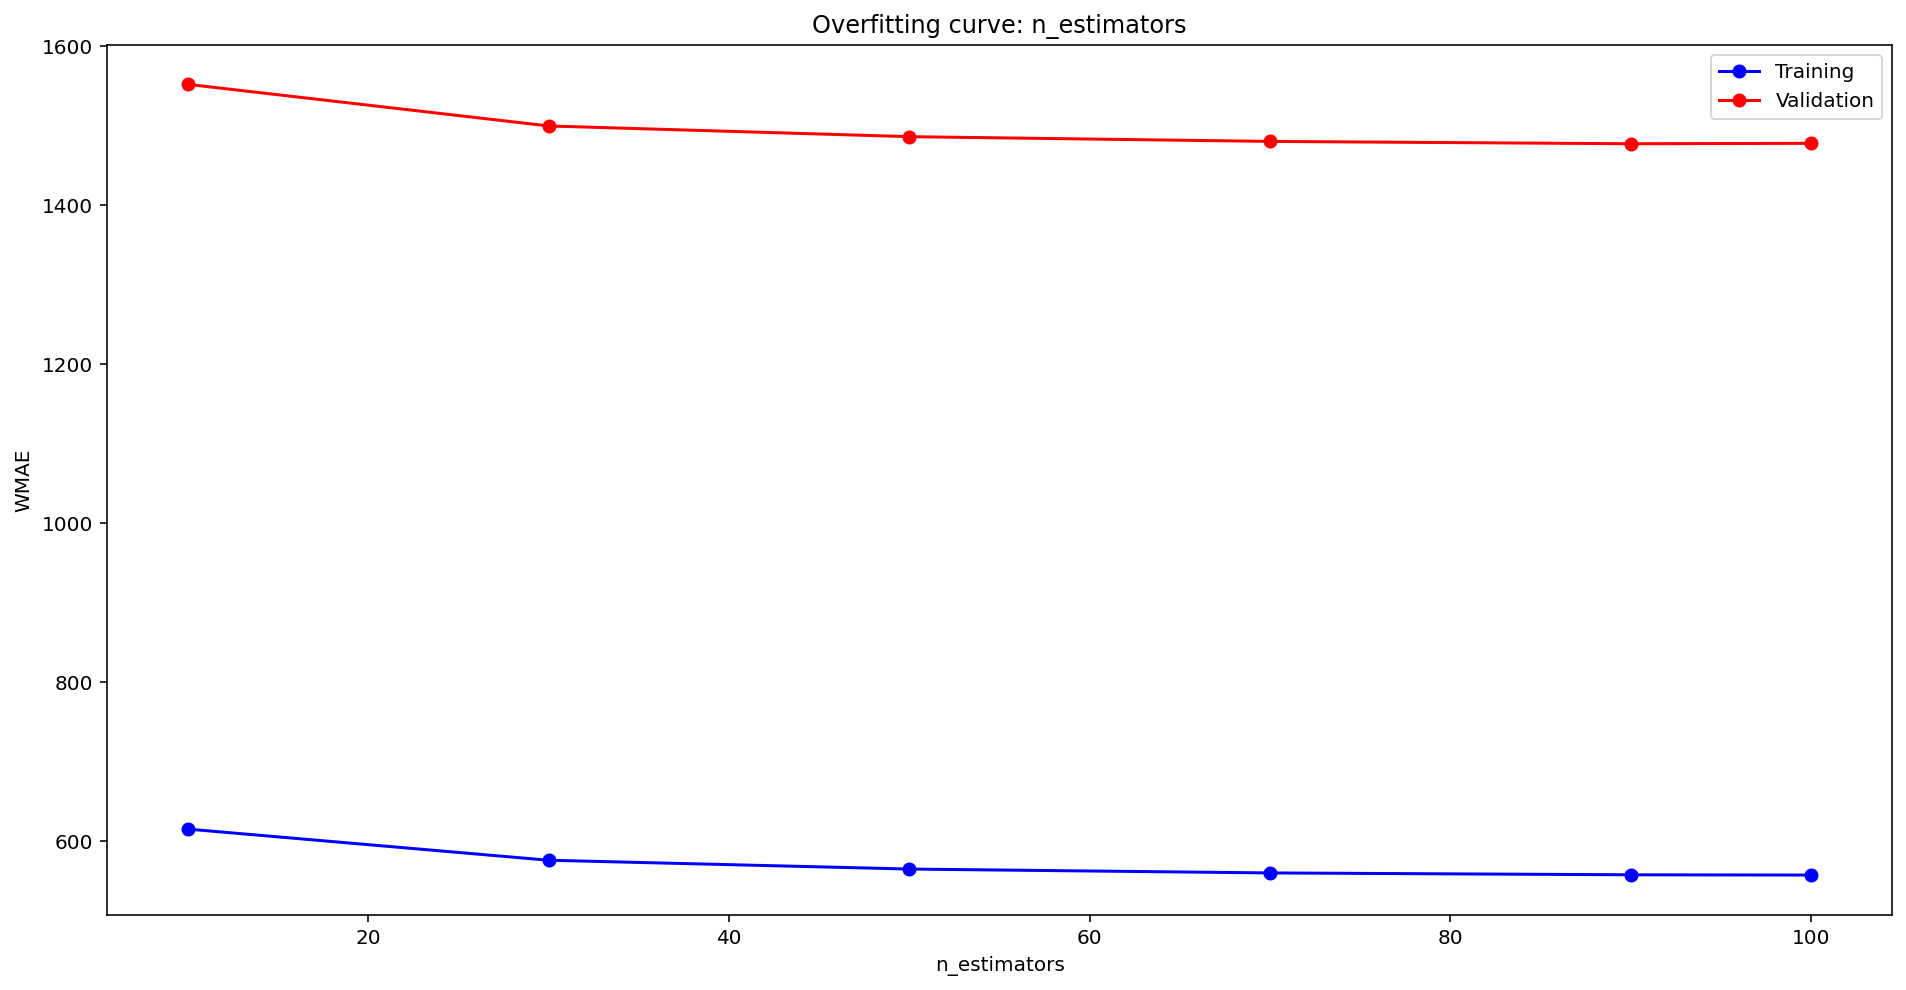

In [ ]:
test_param_and_plot('n_estimators', [10, 30, 50, 70, 90, 100])


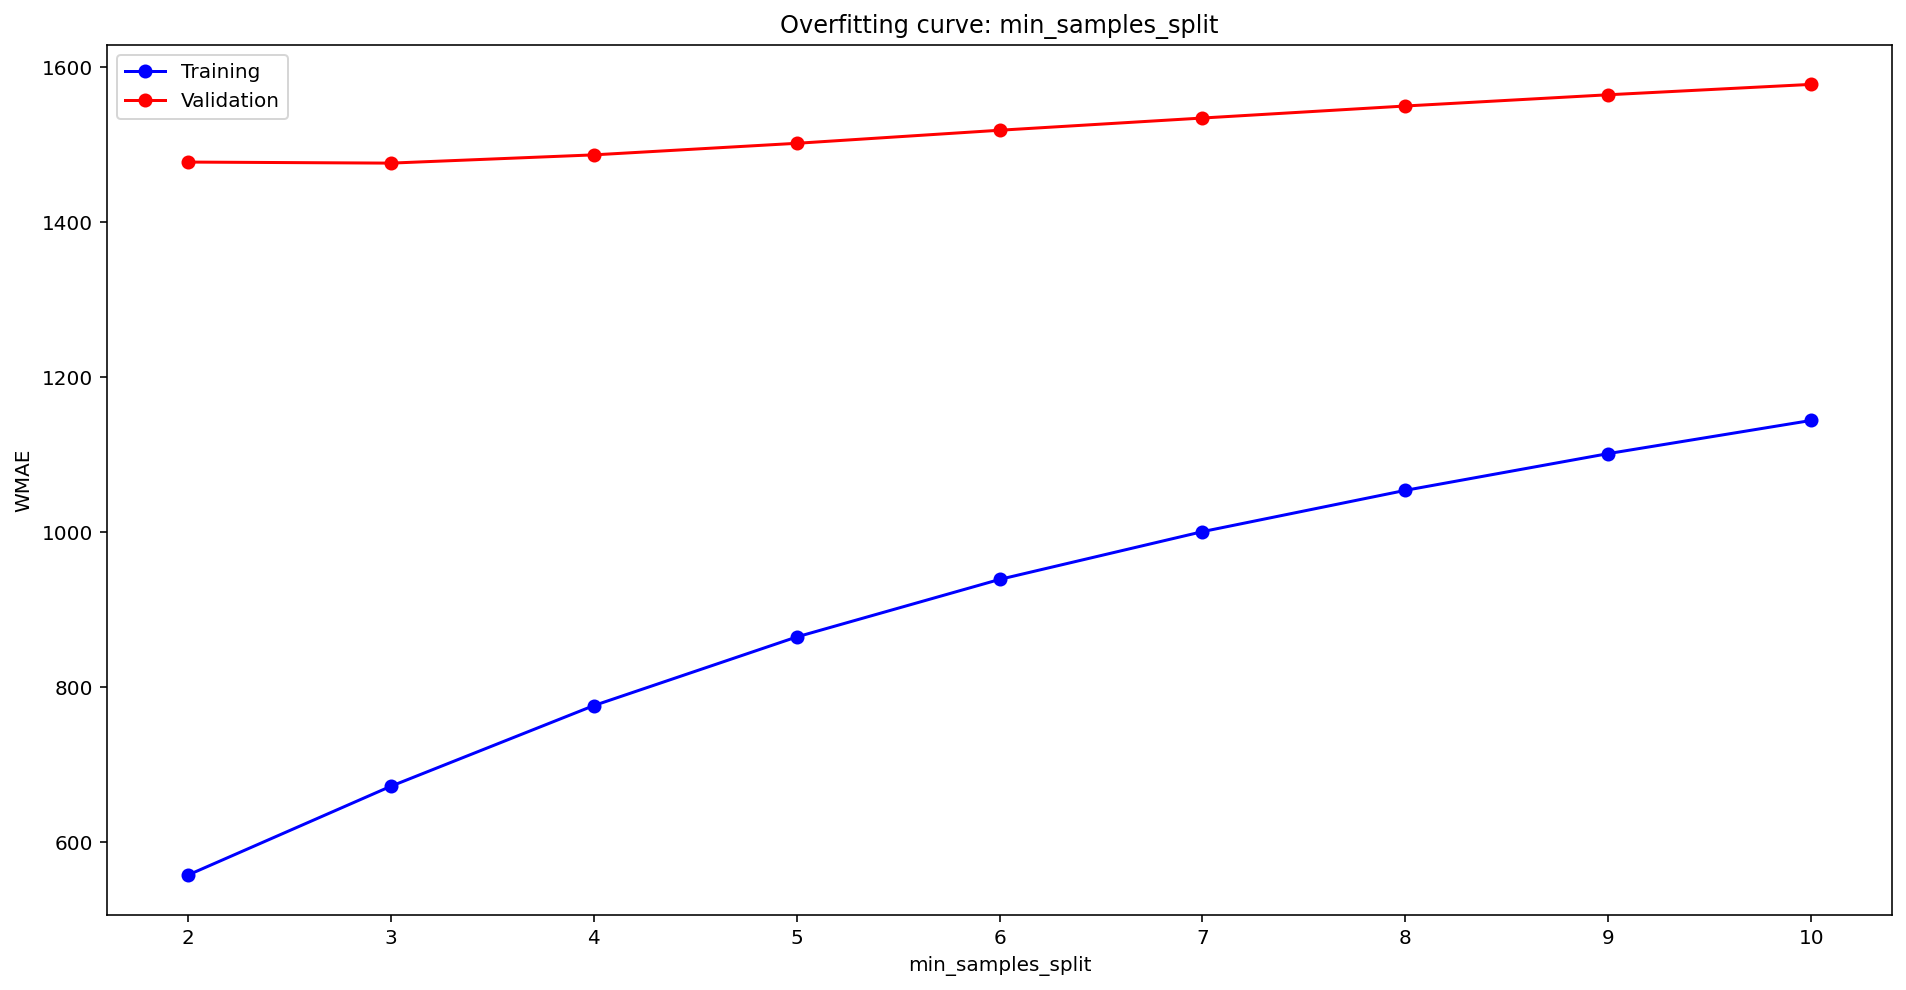

In [ ]:
test_param_and_plot('min_samples_split', [2, 3, 4, 5, 6, 7, 8, 9, 10])

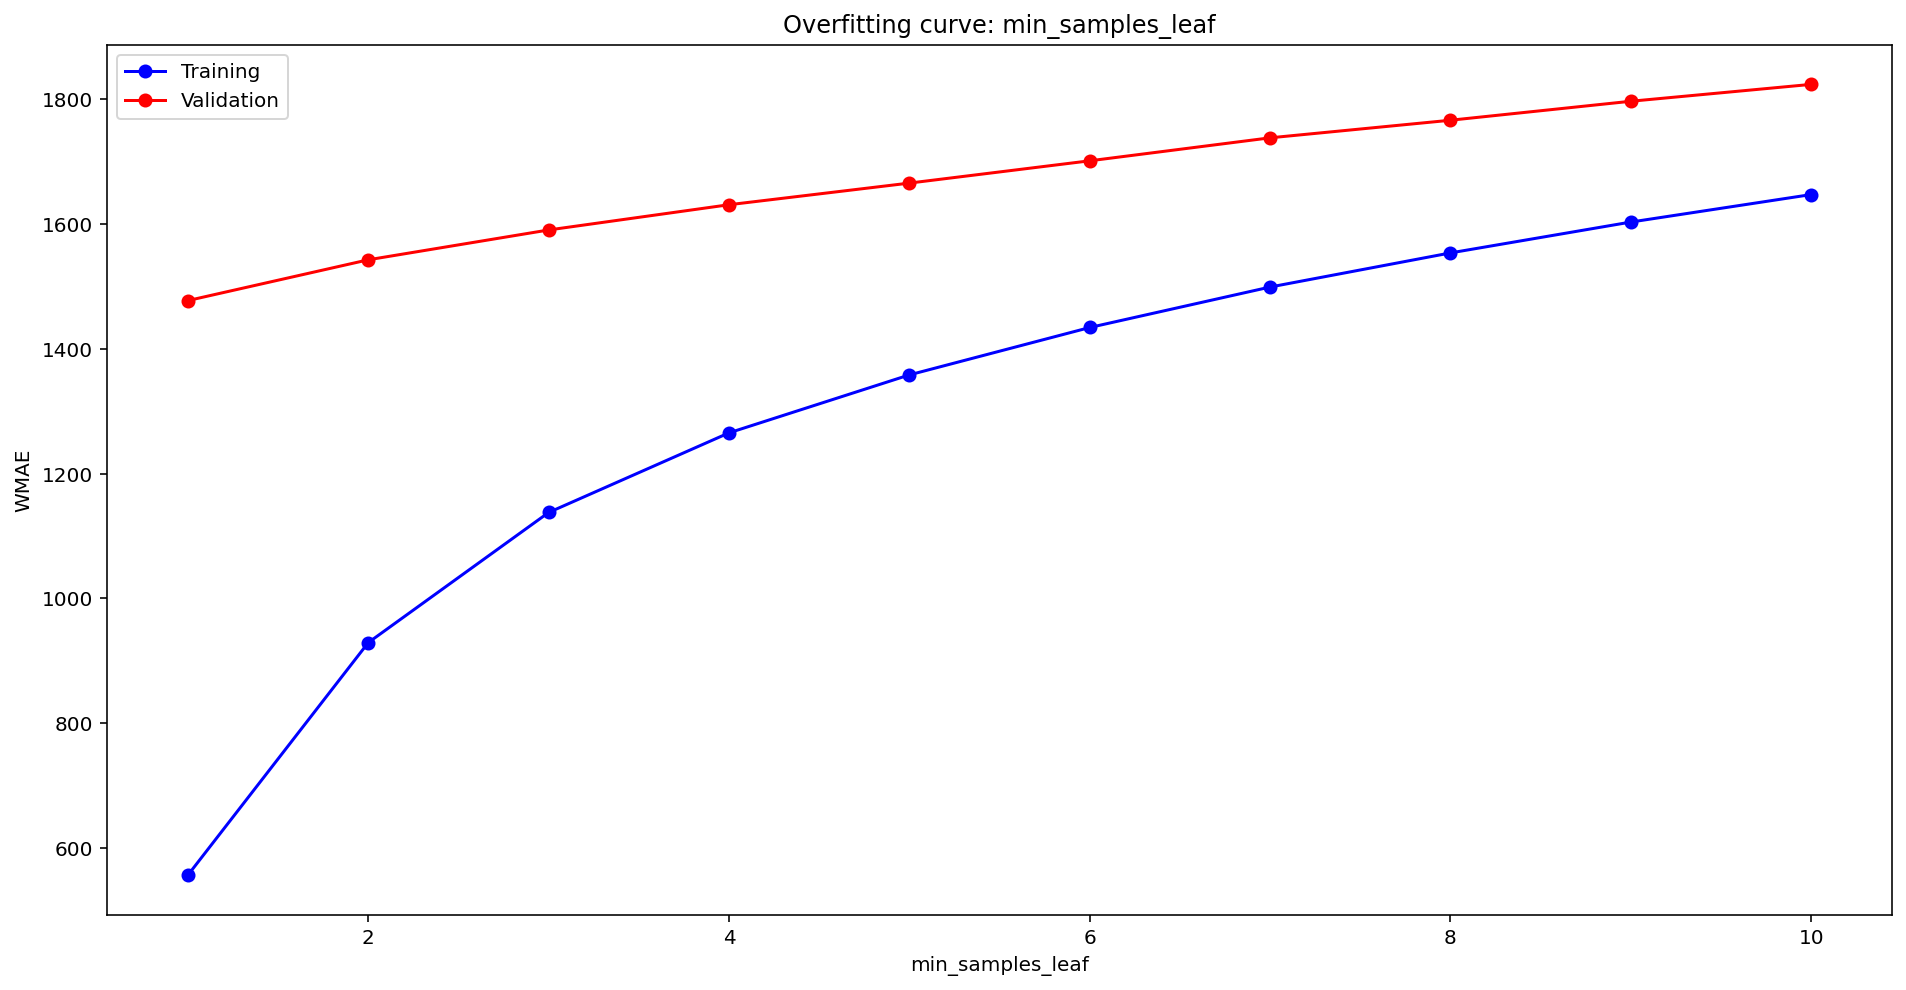

In [ ]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

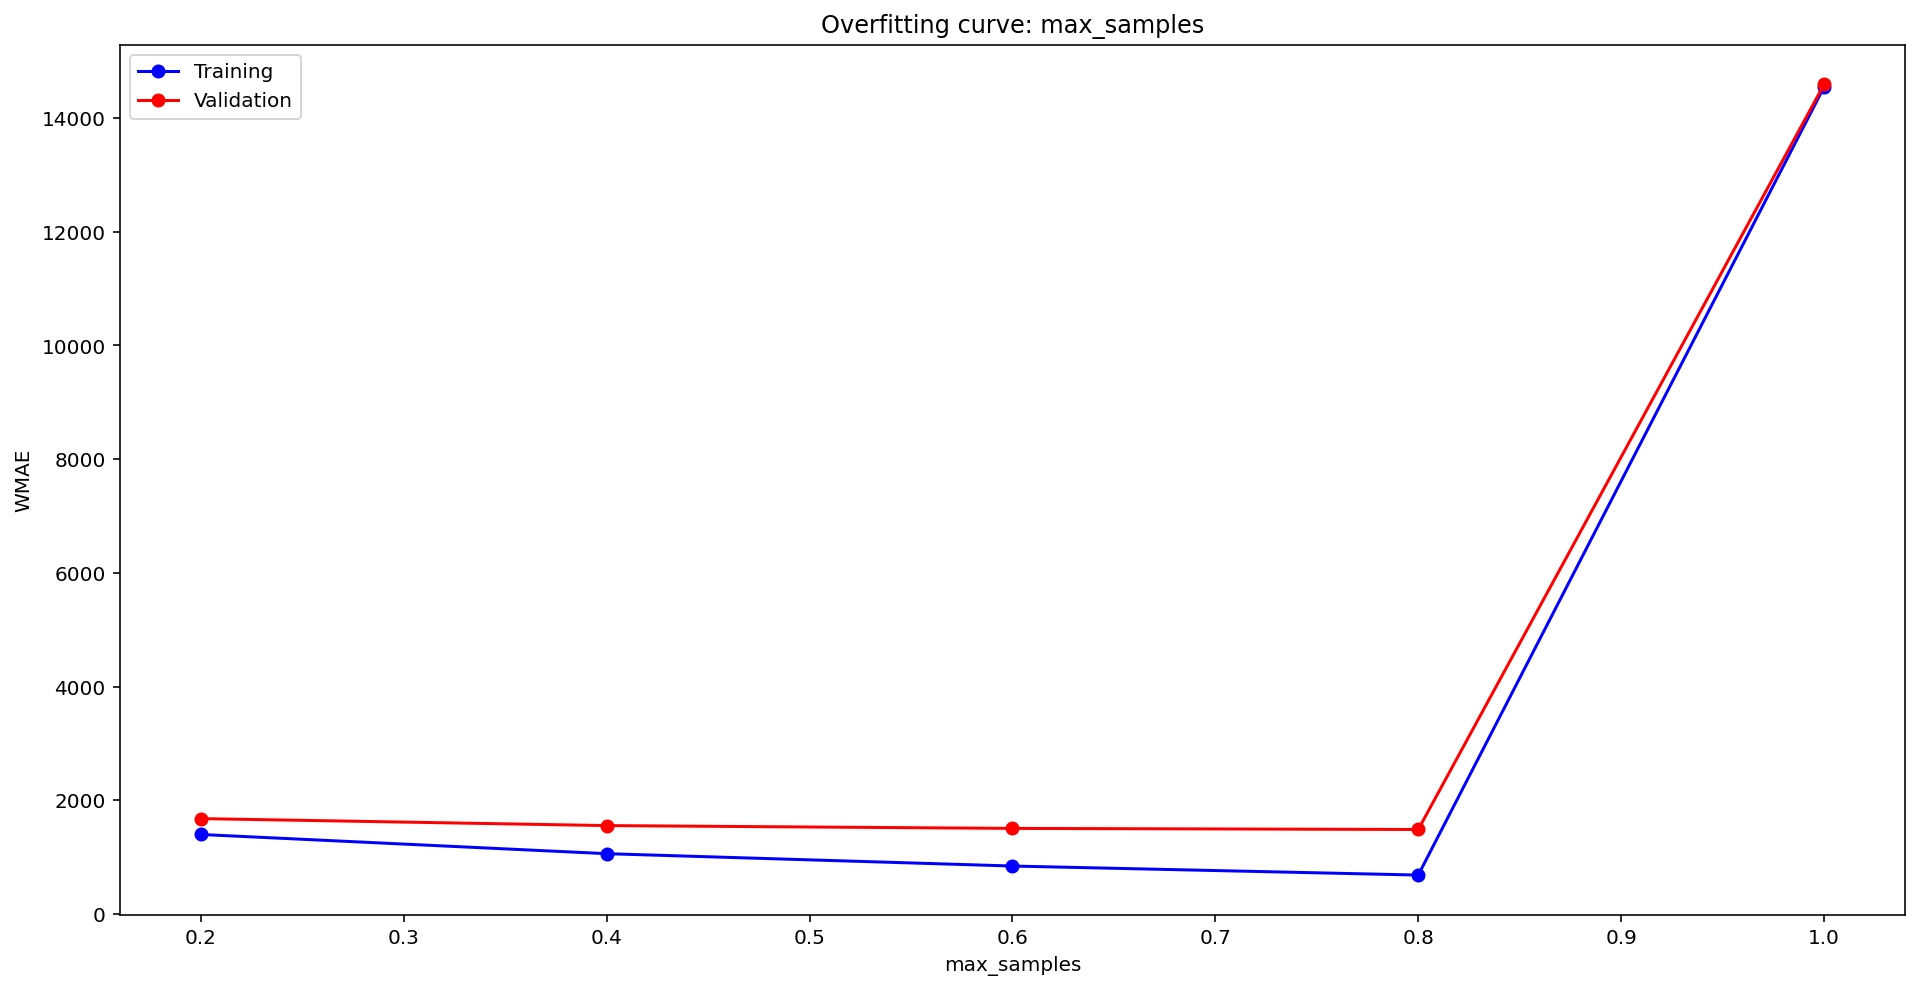

In [ ]:
test_param_and_plot('max_samples', [0.2, 0.4, 0.6, 0.8, 1])


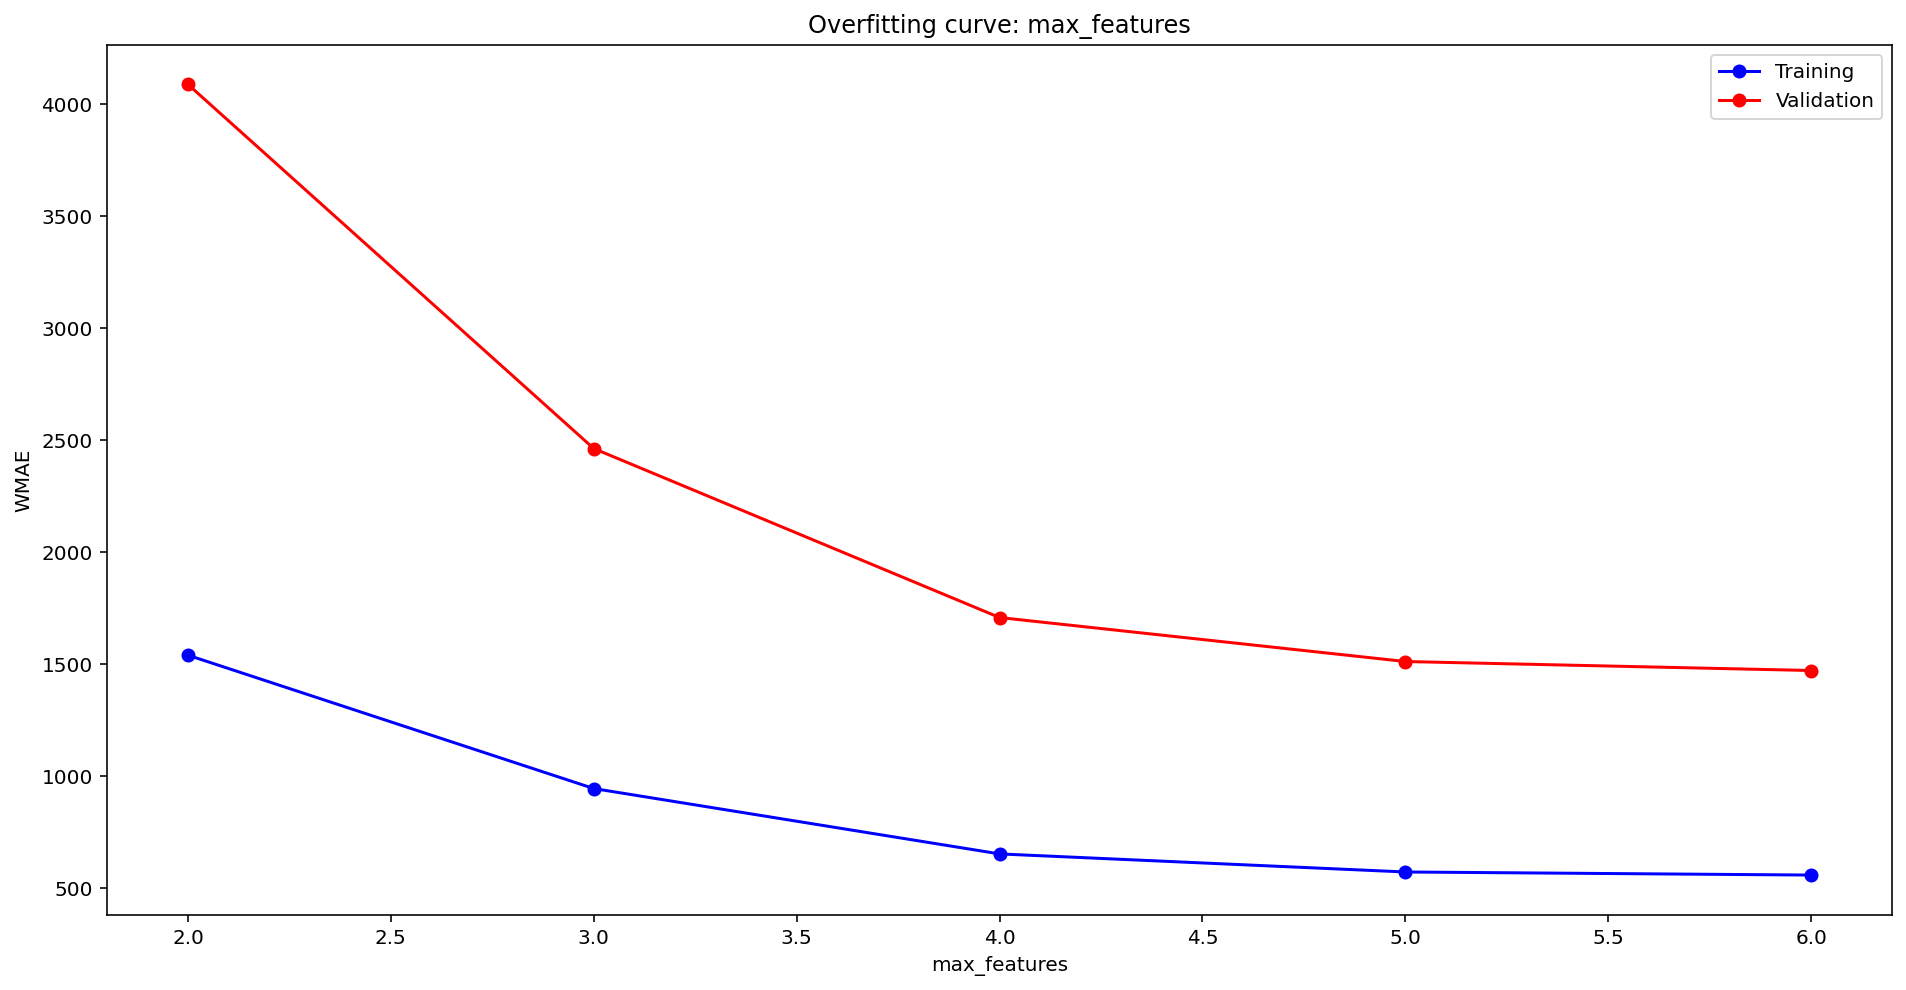

In [ ]:
test_param_and_plot('max_features', [2, 3, 4, 5, 6])


In [ ]:
#Create the model
rf1 = RandomForestRegressor(max_depth=25, n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_samples=0.8, max_features=6,  random_state=123)

# Fit the model
rf1.fit(X_train, y_train)

rf1_train_pred = rf1.predict(X_train)

# Compute WMAE on traing data
rf1_train_wmae = WMAE(X_train, y_train, rf1_train_pred)
print('The WMAE loss for the training set is  {}.'.format(rf1_train_wmae))

rf1_val_preds = rf1.predict(X_val)

# Compute WMAE on validation data
rf1_val_wmae = WMAE(X_val, y_val, rf1_val_preds)
print('The WMAE loss for the validation set is  {}.'.format(rf1_val_wmae))

The WMAE loss for the training set is  710.91.
The WMAE loss for the validation set is  1484.95.


The loss function value of validation dataset of this new RandomForest value is a little bit lower.



5. XgBoosting



In [ ]:
# Create the model
xgb = XGBRegressor(random_state=123)
model5 = xgb.fit(X_train, y_train)
#train error
xgb_train_wmae = WMAE(X_train, model5.predict(X_train), y_train)

#validation error
xgb_pred = model5.predict(X_val)
xgb_val_wmae = WMAE(X_val, xgb_pred, y_val)

#results:
print('Training dataset WMAE is', xgb_train_wmae)
print('Validation dataset WMAE is', xgb_val_wmae)


[10:54:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training dataset WMAE is 7158.14
Validation dataset WMAE is 7161.86


XgBoosting Hyperparameter Tuning



In [ ]:
importance_df_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model5.feature_importances_
}).sort_values('importance', ascending=False)



importance_df_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model4.feature_importances_
}).sort_values('importance', ascending=False)


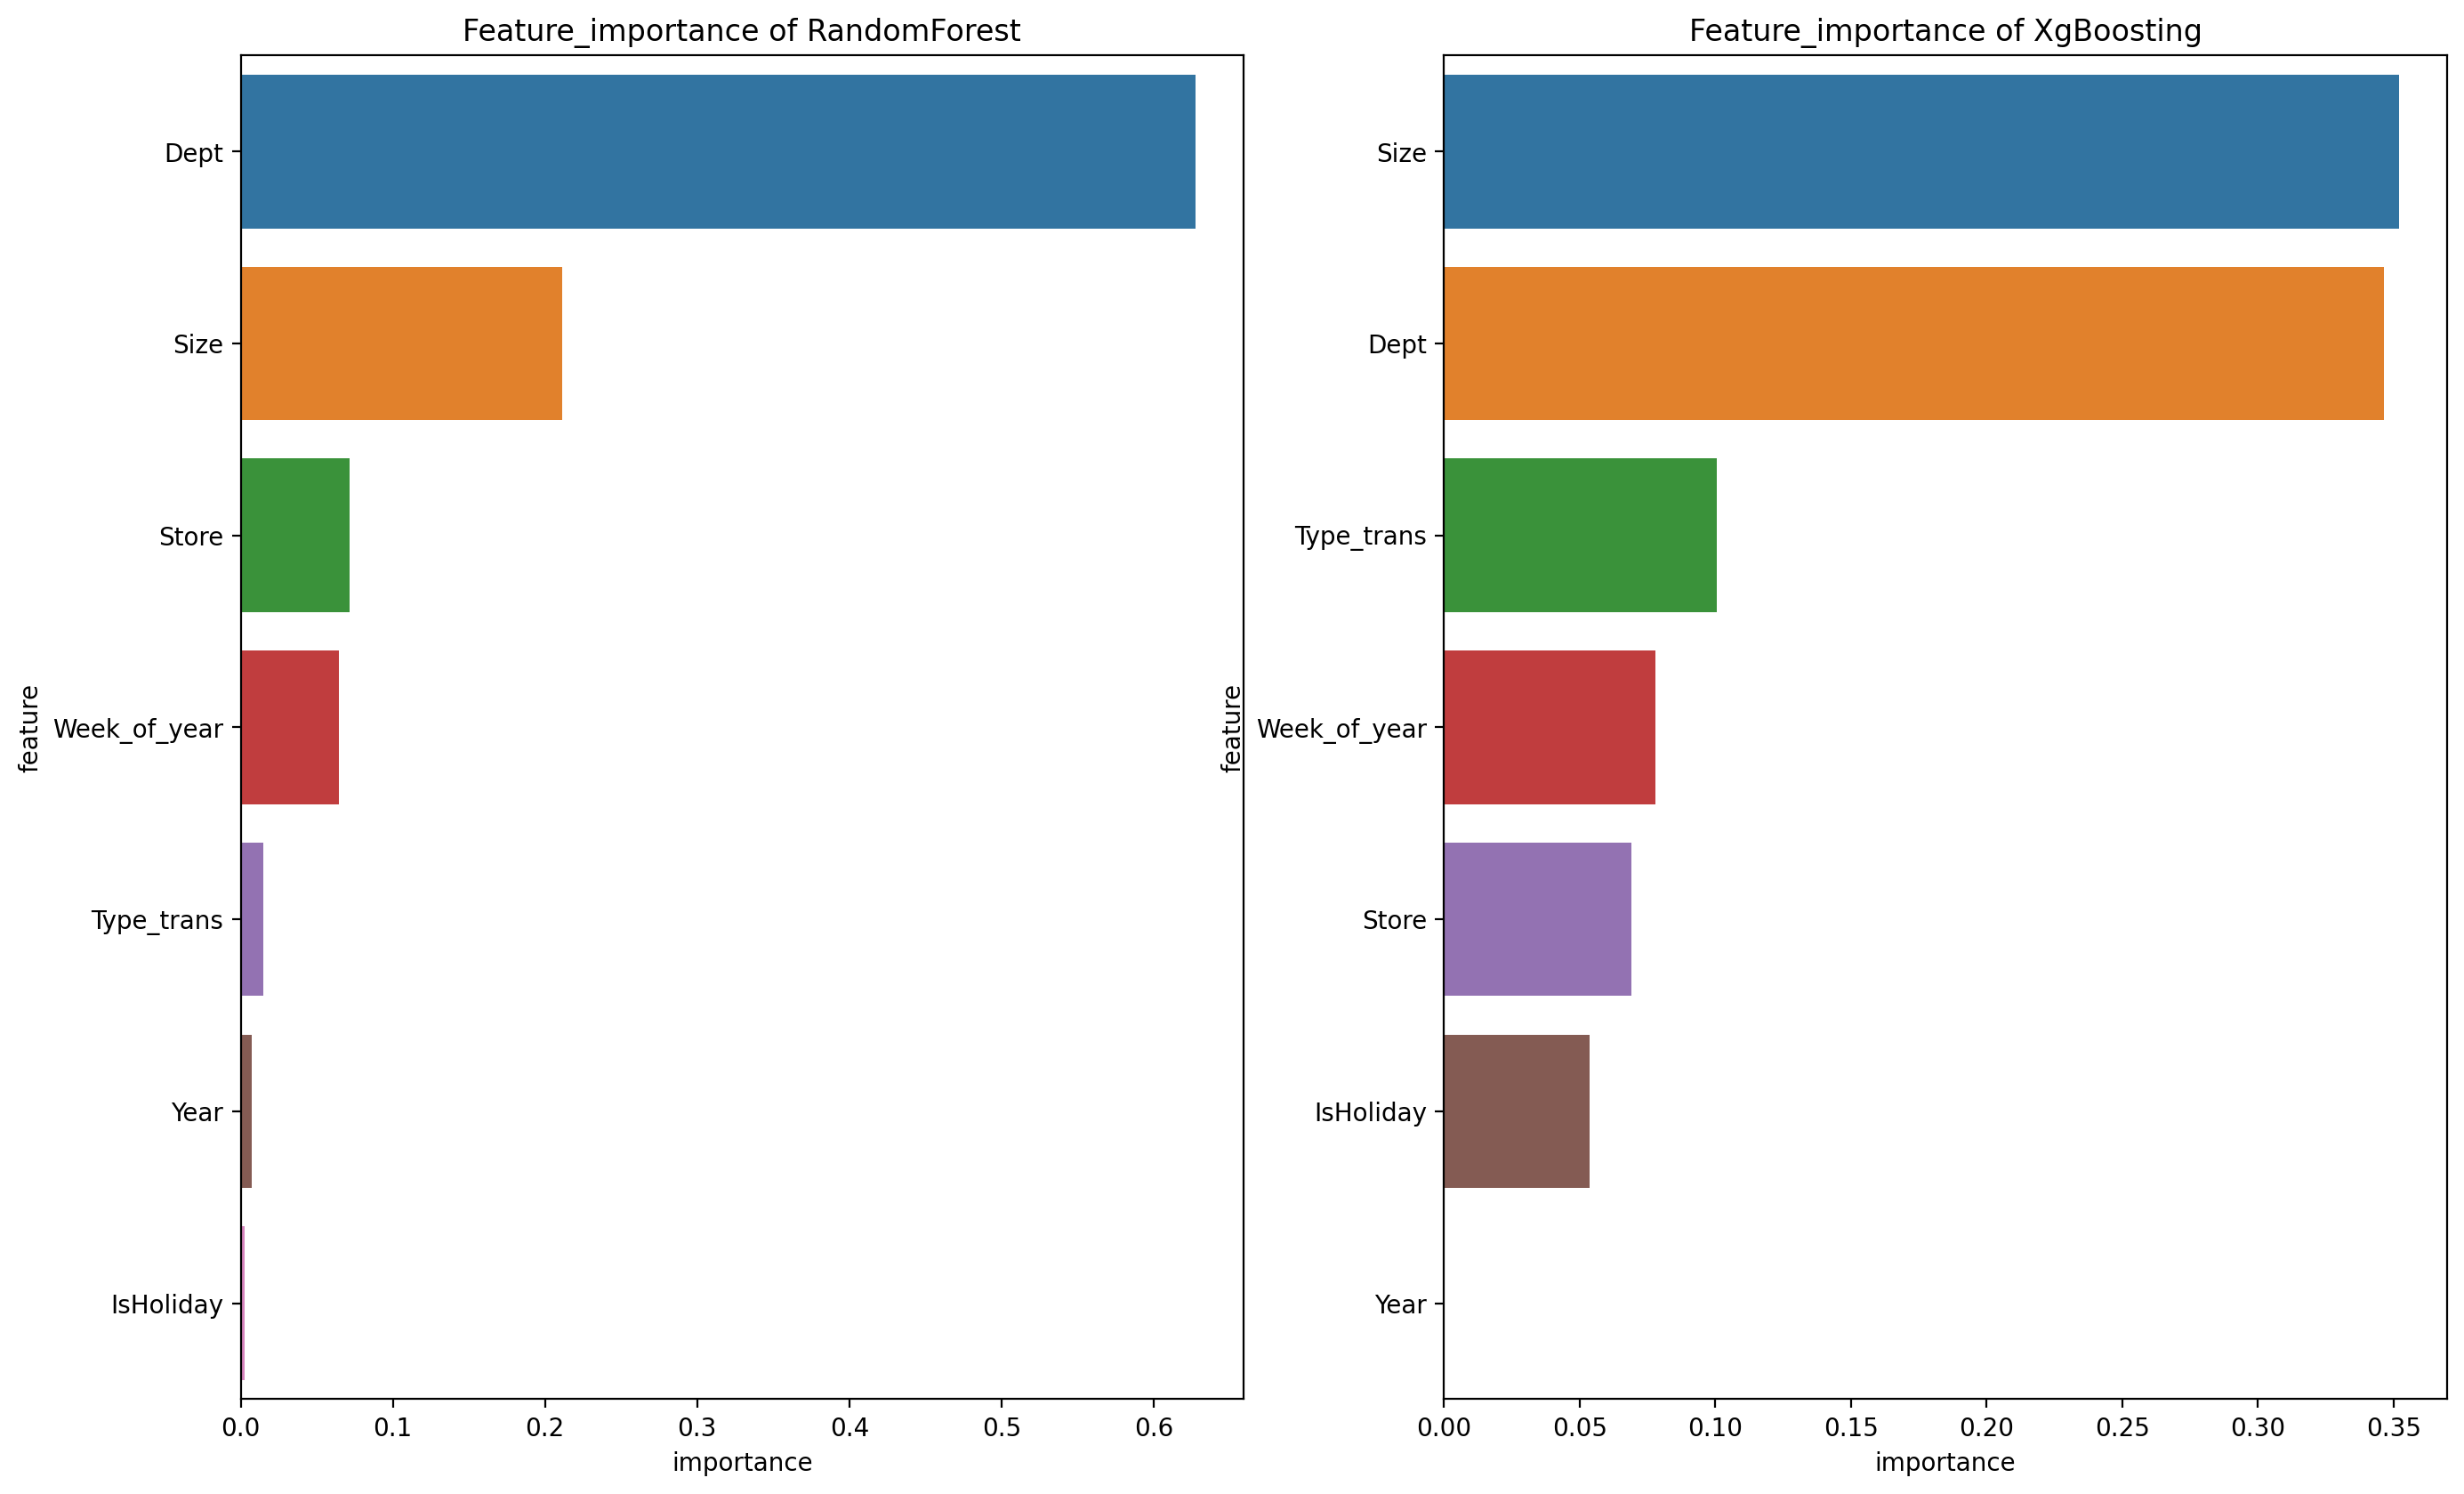

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,10), dpi=100)

ax1 = sns.barplot(data=importance_df_rf, x='importance', y='feature', ax=axes[0])
ax1.set_title('Feature_importance of RandomForest')

ax2 = sns.barplot(data=importance_df_xgb, x='importance', y='feature', ax=axes[1])
ax2.set_title('Feature_importance of XgBoosting')

plt.show()

It seems a little bit different from the model of Randomforest.

The order of importance of all features except Size varies between these two models

Xgboosting Hyperparameter Tuning


In [ ]:
def test_params_xgb(**params):  
    model = XGBRegressor(random_state=123, **params).fit(X_train, y_train)
    train_wmae = WMAE(X_train, y_train, model.predict(X_train))
    val_wmae = WMAE(X_val, y_val, model.predict(X_val))
    return train_wmae, val_wmae

In [ ]:
def test_param_and_plot_xgb(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params_xgb(**params)
        train_errors.append(train_wmae)
        val_errors.append(val_wmae)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('WMAE')
    plt.legend(['Training', 'Validation'])

[10:55:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:56:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:01:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


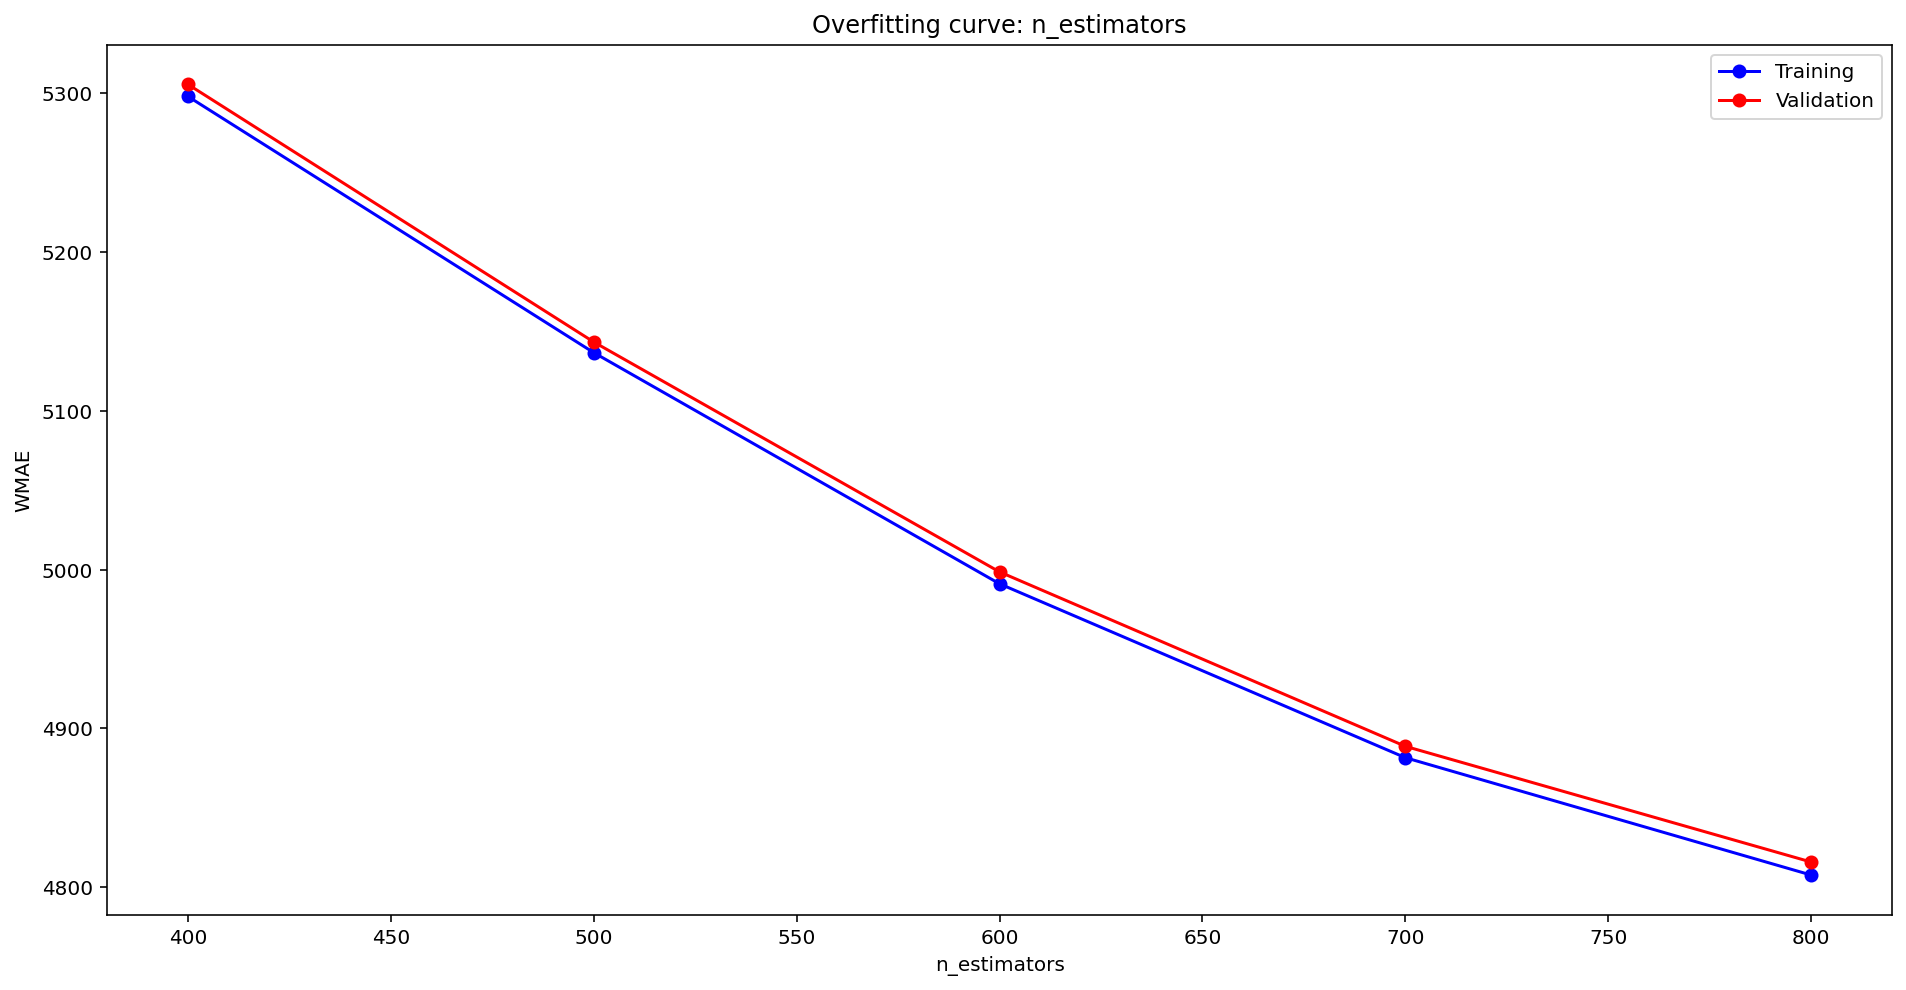

In [ ]:
test_param_and_plot_xgb('n_estimators', [400,500,600,700,800])

[11:04:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:07:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


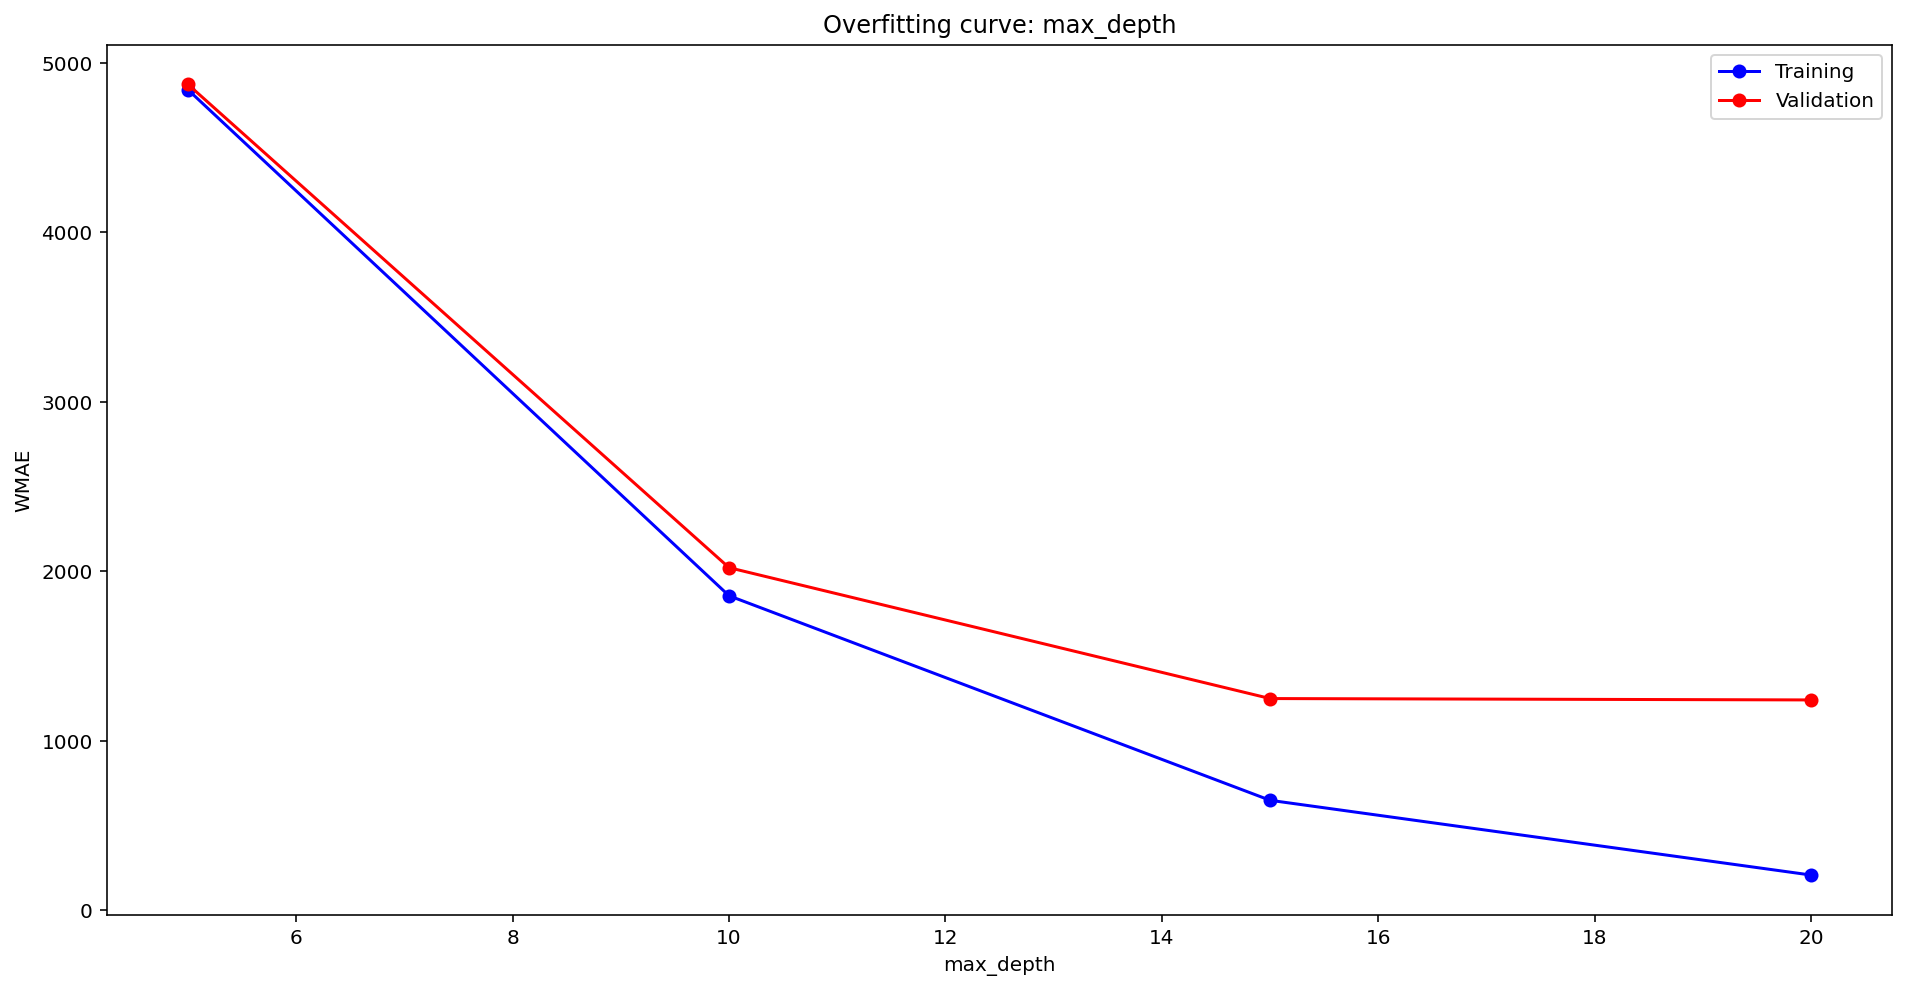

In [ ]:
test_param_and_plot_xgb('max_depth', [5, 10, 15, 20])

In [ ]:
test_param_and_plot_xgb('learning_rate', [0.1, 0.2, 0.4, 0.6, 0.8])

In [ ]:
test_param_and_plot_xgb('reg_alpha', [0, 0.25, 0.5, 0.75, 1])

In [ ]:
test_param_and_plot_xgb('reg_lambda', [0, 0.05, 0.1, 0.15, 0.2])

In [ ]:
kk;
''









|
# Create the model
xgb1 = XGBRegressor(random_state=123, n_estimators=800,
                    learning_rate = 0.6, max_depth=15)

# Fit the model
xgb1.fit(X_train, y_train)



# Compute WMAE on traing data
xgb1_train_preds = xgb1.predict(X_train)
xgb1_train_wmae = WMAE(X_train, y_train, xgb1_train_preds)
print('The WMAE loss for the training set is  {}.'.format(xgb1_train_wmae))



# Compute WMAE on validation data
xgb1_val_preds = xgb1.predict(X_val)
xgb1_val_wmae = WMAE(X_val, y_val, xgb1_val_preds)
print('The WMAE loss for the validation set is  {}.'.format(xgb1_val_wmae))

SyntaxError: ignored

Models Comparison


Linear Regression

WMAE for Training set: 14776.33

WMAE for Validation set: 14884.34

WMAE for Training set: 14839.35

WMAE for Validation set: 14774.52

WMAE for Training set: 0.0

WMAE for Validation set:

WMAE for Training set: 569.99

WMAE for Validation set: 1571.46

WMAE for Training set: 16.66

WMAE for Validation set: 1339.29

1.Linear Regression

Training dataset WMAE is 14839.38
Validation dataset WMAE is 14774.55

2.Ridge Regression

Training dataset WMAE is 14839.35
Validation dataset WMAE is 14774.52

3.Decision Tree

Training dataset WMAE is 0.0
Validation dataset WMAE is 1781.92

4.Random Forest

The WMAE loss for the training set is 711.43.
The WMAE loss for the validation set is 1471.64.

5.Gradient Boosting Machine

The WMAE loss for the training set is 0.03.
The WMAE loss for the validation set is 1368.12.








#Conclusions

Following inferences and conclusions can be drawn from the the analysis of the data:

Type 'A' stores are more popular than 'B' and 'C' types.

Type 'A' stores outclass the 'B' and 'C' types in terms of size and the avergae weekly sales.

Weekly Sales are affected by the week of year. Holiday weeks witnessed more sales than the non-holiday weeks. Notables are Thanksgiving and Christmas weeks.

Size of the store is a major contributing factor in the weekly sales.

Sales are also dependent on the department of the store as different departments showed different levels of weekly sales.

Among the trained models for predicting the future sales, Grdient Boosting Machine with tuned hyperparameters performs the best.




